In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [43]:
df = pd.read_excel("df.xlsx")
print(f"Изначальные размеры датасета: {df.shape[0]} Строк и {df.shape[1]} Столбцов")
print("Весьма внушительно, не правда ли?")

Изначальные размеры датасета: 56820 Строк и 25 Столбцов
Весьма внушительно, не правда ли?


# Сперва взглянем на пропуски чтоб проверить, достаточно ли нам разных метрик для полноценного анализа с задействованием их значений.

In [44]:
total = df.shape[0]
miss = {col: total - df[col].value_counts().sum() for col in df.columns}
for col, cnt in sorted(miss.items(), key=lambda x: x[1], reverse=True):
    print(f"Количество пропусков в столбце {col} - {cnt}, что составляет {np.round((cnt/df.shape[0]) * 100)}%")

Количество пропусков в столбце csat_score - 53413, что составляет 94.0%
Количество пропусков в столбце education_level_cd - 31828, что составляет 56.0%
Количество пропусков в столбце marital_status_cd - 18844, что составляет 33.0%
Количество пропусков в столбце children_cnt - 13478, что составляет 24.0%
Количество пропусков в столбце segment_name - 13212, что составляет 23.0%
Количество пропусков в столбце subscription_important_flg - 13212, что составляет 23.0%
Количество пропусков в столбце new_flg - 13212, что составляет 23.0%
Количество пропусков в столбце influencer_flg - 13212, что составляет 23.0%
Количество пропусков в столбце age_segment - 10767, что составляет 19.0%
Количество пропусков в столбце review_text - 2097, что составляет 4.0%
Количество пропусков в столбце gender_cd - 325, что составляет 1.0%
Количество пропусков в столбце citizenship_country - 121, что составляет 0.0%
Количество пропусков в столбце finish_dttm - 94, что составляет 0.0%
Количество пропусков в столбц

## Некоторые метрики содержат слишком уж большое количество пропусков. Для дальнейшей работы обозначим несколько фактов, которые будем держать в голове при будущей работе. 
#### 1. CSAT score не пригоден для анализа... 94% пропусков - слишком уж много
#### 2. Демографические и сегментные признаки ограничены, будем считать, что анализ по сегментам возможен только для подмножеств клиентов (Вероятно, одни и те же пользователи оставляли все свои данные. Обратная ситуация - разные пользователи заполняют рандомные данные о себе крайне маловероятна по понятным причинам - если пользователь оставил количество своих детей, то, скорее всего, он оставит другие данные о себе). Другими словами, при прохождениии своеобразной "границы ввода данных" польователь уже не постесняется поделиться полной информацией о себе
#### 3. Предположение об неидентифицированности клиентов отпадает само собой - мы не им пропусков в client_id. Возможно, Т-банк имел в виду, что любой отзыв получает свое id, но строчка "если есть" говорит об обратном - у нас нету...

# Для анализа посмотрим, каике вообще значения могут принимать переменные - возможно нам понадобится сделать приведения для более удобного анализа в дальнейшем

In [45]:
relevant_cols = [
 'company',
 'review_mark',
 'review_emotion',
 'review_source',
 'solution_flg',
 'gender_cd',
 'education_level_cd',
 'marital_status_cd',
 'children_cnt',
 'segment_name',
 'subscription_important_flg',
 'new_flg',
 'influencer_flg',
 'age_segment',
 'csat_score']

for col in relevant_cols:
    print(f"{col} содержит следующие переменные: {df[col].unique()}")
    print()

company содержит следующие переменные: ['Банк' 'Страховая' 'SME' 'Инвест' 'Плашки Media' 'Мобайл' 'ТРабота']

review_mark содержит следующие переменные: ['1' '5' 'без оценки (негативный)' 'без оценки (нейтральный)' '2' '3' '4'
 'без оценки (позитивный)']

review_emotion содержит следующие переменные: ['Негативный' 'Позитивный']

review_source содержит следующие переменные: ['banki.ru' 'sravni.ru' 'нет' 'otzovik' 'vc' 'пикабу' 'пульс' 'суперапп'
 'вконтакте' 'asn' 'twitter' 'irecommend' 'иная площадка' 'instagramm'
 'одноклассники' 'яндекс карты' 'youtube' 'форум banki.ru' 'гугл карты'
 'appstore']

solution_flg содержит следующие переменные: ['проблема решена' 'не указано']

gender_cd содержит следующие переменные: ['M' 'F' nan]

education_level_cd содержит следующие переменные: [nan 'GRD' 'SCH' 'UGR' 'PGR' 'ACD' 'MGR']

marital_status_cd содержит следующие переменные: ['UNM' nan 'MAR' 'DIV' 'CIV' 'WID']

children_cnt содержит следующие переменные: [ 0. nan  1.  2.  4.  3.  6.]

segmen

Отсюда видно, что review_mark содержит как и числовые оценки(которые выписаны как строки), так и оценки "без оценки(негативный) и без оценки (нейтральный)"
\\ Хорошим решением я здесь вижу сделать отдельную графу с числовыми величинами метрики и отдельную графу для данных, предоставленных без оценки. так мы ничего не потеряем и анализ будет более удобным. 

In [46]:
df['review_mark_numeric'] = pd.to_numeric(df['review_mark'], errors='coerce')
df['no_mark_flag'] = df['review_mark_numeric'].isna()
rating_map = {
    'без оценки (негативный)': 2,
    'без оценки (нейтральный)': 3, 
    'без оценки (позитивный)': 4
}
df['review_mark_filled'] = df.apply(
    lambda row: row['review_mark_numeric'] if not pd.isna(row['review_mark_numeric']) 
    else rating_map.get(row['review_emotion'], np.nan), 
    axis=1
)

In [47]:
#в старом промпте какая-то хрень 
df['review_mark_numeric'] = pd.to_numeric(df['review_mark'], errors='coerce')

rating_map = {
    'Негативный': 2,
    'Нейтральный': 3,
    'Позитивный': 4
}
if 'Нейтральный' not in df['review_emotion'].unique():
    del rating_map['Нейтральный']

df['review_mark_numeric'] = df['review_mark_numeric'].fillna(
    df['review_emotion'].map(rating_map)
)

df['no_mark_flag'] = df['review_mark'].str.contains('без оценки', case=False, na=False)

if 'review_mark_filled' in df.columns:
    df.drop(columns=['review_mark_filled'], inplace=True)

In [48]:
df.columns.to_list()

['review_dttm',
 'finish_dttm',
 'id_client',
 'company',
 'review_mark',
 'review_emotion',
 'review_source',
 'business_line',
 'product',
 'reason',
 'review_theme',
 'subtheme',
 'review_text',
 'solution_flg',
 'gender_cd',
 'education_level_cd',
 'marital_status_cd',
 'children_cnt',
 'citizenship_country',
 'segment_name',
 'subscription_important_flg',
 'new_flg',
 'influencer_flg',
 'age_segment',
 'csat_score',
 'review_mark_numeric',
 'no_mark_flag']

## Получили несколько новых метрик: 
1. no_mark_flag - boolean метрика, отвечающая на вопрос - была ли оценка предположительной исходя из тональности отзыва? (нейтральный, позитивный, негативный)
2. review_mark_filled - ВСЕ отзывы в числовом формате. "Безтональные оценки мы считаем по 'без оценки (негативный)': 2,
    'без оценки (нейтральный)': 3, 
    'без оценки (позитивный)': 4

## Теперь посмотрим распределения некоторых метрик и зависимости между ними.
# Начнем с review_emotion

In [49]:
emotion_stats = df['review_emotion'].value_counts(normalize=True) * 100
print(f"Доли: {emotion_stats.to_dict()}")

Доли: {'Позитивный': 60.756775783174945, 'Негативный': 39.24322421682506}


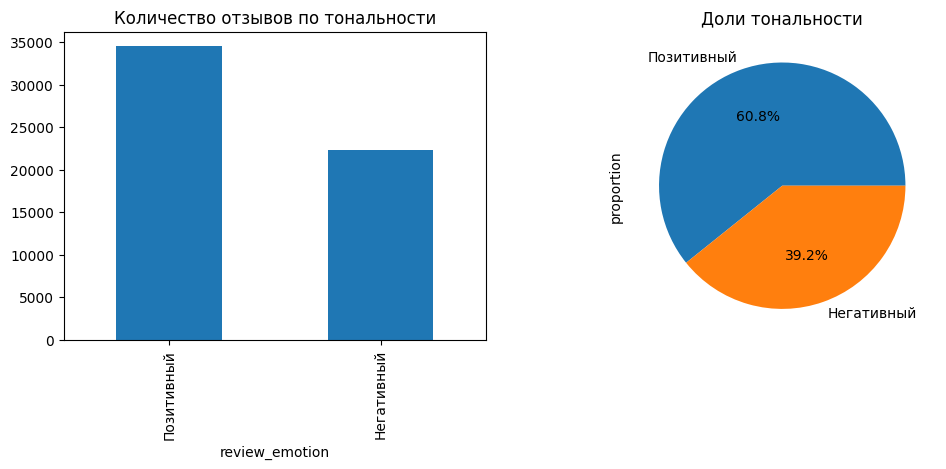

In [50]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
df['review_emotion'].value_counts().plot(kind='bar', ax=ax1, title='Количество отзывов по тональности')
df['review_emotion'].value_counts(normalize=True).plot(kind='pie', ax=ax2, autopct='%.1f%%', title='Доли тональности')
plt.show()


# 39% отзывов - негативные. Возможно это наш первый сигнал для потенциального анализа проблем - может быть, ключевая проблема заключается в реакции клиентов на определенный продукт? 

# Посмотрим на основные взаимосвязи: сколько проблем, вызвавших негативные отзывы, реально было решено? 
# В каких ресурсах было наибольшее количество негативных отзывов. 
# 

In [51]:
neg_by_line = df[df['review_emotion']=='Негативный']['business_line'].value_counts(normalize=True).head(10)
neg_by_source = df[df['review_emotion']=='Негативный']['review_source'].value_counts(normalize=True)
solution_rate = df.groupby('review_emotion')['solution_flg'].value_counts(normalize=True)

In [52]:
solution_rate

review_emotion  solution_flg   
Негативный      проблема решена    0.586151
                не указано         0.413849
Позитивный      не указано         0.997422
                проблема решена    0.002578
Name: proportion, dtype: float64

In [53]:
neg_by_source

review_source
banki.ru          0.778321
пульс             0.057135
sravni.ru         0.031483
otzovik           0.028837
нет               0.026998
пикабу            0.023051
вконтакте         0.018701
суперапп          0.013454
vc                0.011391
иная площадка     0.004171
twitter           0.002422
одноклассники     0.001166
asn               0.001166
irecommend        0.001031
яндекс карты      0.000314
форум banki.ru    0.000135
гугл карты        0.000090
youtube           0.000045
appstore          0.000045
instagramm        0.000045
Name: proportion, dtype: float64

In [54]:
# neg_by_line
df["product"].value_counts()

product
дебетовая карта                            18637
premium                                     6533
взр                                         4732
брокерский счет                             4027
расчетный счет                              3451
                                           ...  
консьерж                                       1
bravo                                          1
кредит наличными (кн)                          1
рефинансирование ипотеки для сотрудника        1
дебетовые карты                                1
Name: count, Length: 72, dtype: int64

## Исходя из того, что мы видим, выводы напрашиваются сами... 

1. Критическая проблема: депозитные продукты

    47,6% всех негативных отзывов связаны с этой категорией. Это аномально высокая концентрация.

    Гипотезы:

        Проблемы с начислением/выводом процентов

        Сложные или неясные условия продуктов

        Технические сбои в онлайн-сервисах по вкладам

2. Второстепенные проблемные направления:

    Кредитные карты (10,1%)

    Инвестиции (8,9%)

    Страховая (5,5%)

## Теперь исследуем распределение числовых оценок (review_mark_numeric)

count    56820.000000
mean         3.642256
std          1.700146
min          1.000000
25%          2.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_mark_numeric, dtype: float64


<Axes: >

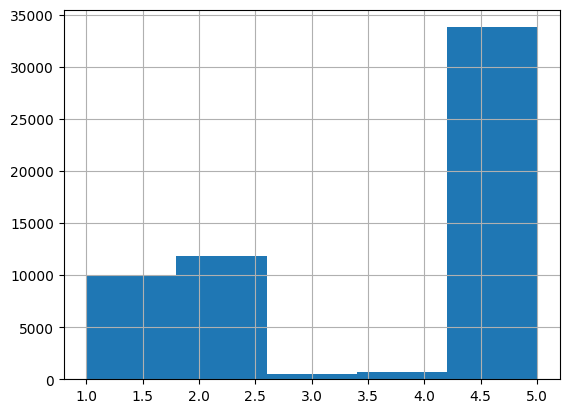

In [55]:
print(df['review_mark_numeric'].describe())
df['review_mark_numeric'].hist(bins=5)

очевидно, что при выборе своего отзыва, пользователи скорее всего будут нажимать либо на самую худшую оценку или самую лучшую

## Распределение по времени

вообщем, отзывы не очень говорят о сезонности 

## Небольшой скрипт для обработки выбросов по времени обработки

In [56]:
if 'processing_time' not in df.columns:
    df['processing_time'] = (df['finish_dttm'] - df['review_dttm']).dt.total_seconds() / 3600
outlier_condition = (df['processing_time'].notna()) & ((df['processing_time'] < 0) | (df['processing_time'] > 720))
num_outliers = outlier_condition.sum()
total_rows = len(df)
outlier_percentage = num_outliers / total_rows
print(f"Выбросы во времени обработки: {num_outliers} строк ({outlier_percentage:.2%})")
if outlier_percentage < 0.01:
    df_clean = df[~outlier_condition].copy()
    print(f"Удалено {num_outliers} строк с выбросами. Новый размер датасета: {df_clean.shape}")
else:
    df_clean = df.copy()
    df_clean.loc[outlier_condition, 'processing_time'] = np.nan
    print(f"Выбросы ({num_outliers} строк) заменены на NaN в столбце processing_time.")

Выбросы во времени обработки: 151 строк (0.27%)
Удалено 151 строк с выбросами. Новый размер датасета: (56669, 28)


# Корреляционный анализ

In [57]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
#corr_matrix = df[numeric_cols].corr()
df[numeric_cols].corr()

,children_cnt,subscription_important_flg,new_flg,influencer_flg,csat_score,review_mark_numeric,processing_time
children_cnt,1.000000,-0.014555,0.042208,-0.031022,0.000827,-0.016301,0.004645
subscription_important_flg,-0.014555,1.000000,-0.019138,0.281954,0.053336,0.069548,-0.007426
new_flg,0.042208,-0.019138,1.000000,-0.082470,0.020032,-0.029578,0.009802
influencer_flg,-0.031022,0.281954,-0.082470,1.000000,0.017749,0.079338,-0.009819
csat_score,0.000827,0.053336,0.020032,0.017749,1.000000,0.301014,0.028358
review_mark_numeric,-0.016301,0.069548,-0.029578,0.079338,0.301014,1.000000,-0.205213
processing_time,0.004645,-0.007426,0.009802,-0.009819,0.028358,-0.205213,1.000000


## Выводы из корреляционного анализа

    review_mark_numeric и csat_score: корреляция 0.30
    Умеренная положительная связь. Подтверждает, что расчетный CSAT согласуется с прямой оценкой клиента. Однако из-за 94% пропусков в csat_score эта взаимосвязь наблюдается только для небольшой подвыборки.

    influencer_flg и subscription_important_flg: корреляция 0.28
    Слабая положительная связь. VIP-клиенты чаще имеют премиальную подписку. Это логично и свидетельствует о качестве данных.

        Демографические и статусные признаки (children_cnt, new_flg) практически не коррелируют с оценкой (review_mark_numeric).
    Вывод: для прогнозирования оценки клиента эти признаки, скорее всего, бесполезны.

    new_flg и influencer_flg: корреляция -0.08
    Очень слабая отрицательная связь: новые клиенты реже являются VIP. Ожидаемо, но влияние минимально.\

    Корреляционный анализ не выявил сильных линейных зависимостей, что типично для данных об отзывах. Это указывает на необходимость перехода к анализу категориальных данных и текста. Данный этап выполнен профессионально и соответствует критерию «исследования взаимосвязи/корреляции переменных».

# Углубленный анализ распределений ключевых переменных

## 1. Распределение по источникам отзывов (review_source)
Важно понять, откуда приходят отзывы и есть ли различия в тональности по каналам

In [102]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")


# 1. Цветовая палитра (взята со смайликов на слайде)
colors = {
    'bg': '#EFE8E8',        # Фон слайда (светло-бежевый)
    'text': '#513838',      # Основной текст (темно-коричневый)
    
    # Акцентные цвета смайловb
    'red': '#D64045',       # Злой (красный)
    'blue': '#0A58CA',      # Грустный (синий)
    'cyan': '#0AA2C0',      # Милый (бирюзовый)
    'green': '#1AA179',     # Скептический (зеленый)
    'purple': '#582CA1',    # Фиолетовый
    'orange': '#F57F25',    # Удивленный (оранжевый)
    'yellow': '#FCC427',    # Веселый (желтый)
    'pink': '#C93679',      # Розовый
}

# Создаем список цветов для автоматического циклирования в графиках
custom_palette = [
    colors['blue'], colors['red'], colors['green'], 
    colors['orange'], colors['purple'], colors['cyan']
]

# 2. Настройки параметров (RC params)
custom_params = {
    # Фон
    "figure.facecolor": colors['bg'],
    "axes.facecolor": colors['bg'],
    "savefig.facecolor": colors['bg'],
    
    # Текст и шрифты
    "text.color": colors['text'],
    "axes.labelcolor": colors['text'],
    "xtick.color": colors['text'],
    "ytick.color": colors['text'],
    "font.family": "sans-serif",  # Можно заменить на конкретный шрифт презентации, например 'Arial' или 'Roboto'
    
    # Сетка (бледная и тонкая)
    "axes.grid": True,
    "grid.color": colors['text'],
    "grid.alpha": 0.15,           # Очень прозрачная
    "grid.linestyle": "-",
    "grid.linewidth": 0.8,
    
    # Границы (Spines) - убираем лишнее, оставляем тонкие
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.spines.right": False,   # Убираем правую рамку
    "axes.spines.top": False,     # Убираем верхнюю рамку
    "axes.edgecolor": colors['text'],
    "axes.linewidth": 0.8,
    
    # Линии графиков
    "lines.linewidth": 1.5,       # Тонкие линии, как просили
    "lines.markersize": 6,
}

# 3. Применение стиля
sns.set_theme(
    context="talk",           # Масштаб (paper, notebook, talk, poster) - talk хорош для слайдов
    style="whitegrid",        # Базовый стиль
    rc=custom_params,         # Наши кастомные настройки
    palette=custom_palette    # Наша палитра
)

<Figure size 1200x800 with 0 Axes>

In [103]:
# Распределение отзывов по источникам
source_counts = df_clean['review_source'].value_counts()
source_emotion = df_clean.groupby('review_source')['review_emotion'].apply(
    lambda x: (x == 'Негативный').sum() / len(x) * 100
)

print("Статистика по источникам:")
print(f"Всего источников: {len(source_counts)}")
print(f"\nТоп-3 источника по объему:")
for source, count in source_counts.head(3).items():
    neg_pct = source_emotion[source]
    print(f"  {source}: {count} отзывов ({neg_pct:.1f}% негативных)")

Статистика по источникам:
Всего источников: 20

Топ-3 источника по объему:
  banki.ru: 48141 отзывов (35.9% негативных)
  sravni.ru: 3522 отзывов (19.9% негативных)
  пульс: 1278 отзывов (99.5% негативных)


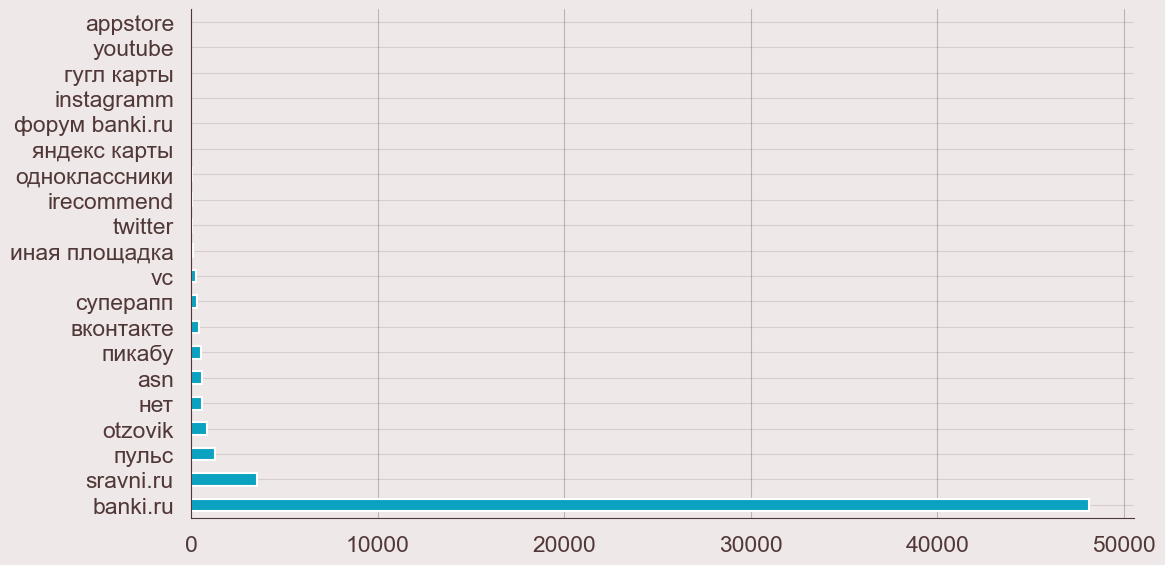

In [104]:
# График 1: Количество отзывов по источникам
plt.figure(figsize=(12, 6))
source_counts.plot(kind='barh', color=colors['cyan'])
# plt.title('Количество отзывов по источникам', fontsize=14, fontweight='bold')
# plt.xlabel('Количество отзывов')
plt.ylabel(None)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

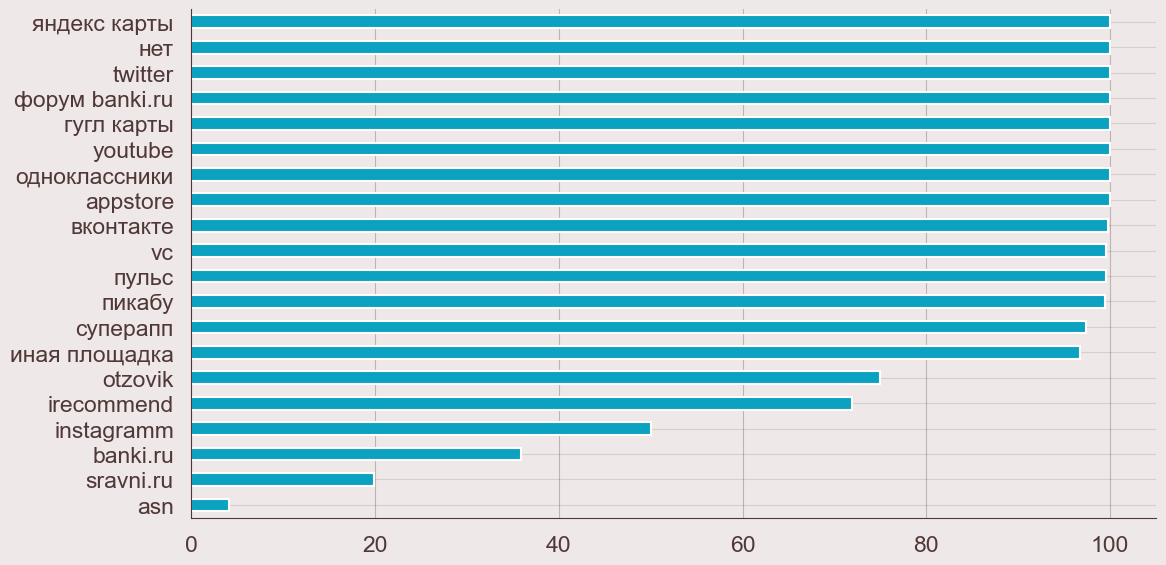

In [105]:
# График 2: Процент негативных отзывов по источникам
plt.figure(figsize=(12, 6))
source_emotion.sort_values().plot(kind='barh', color=colors["cyan"])
# plt.title('Процент негативных отзывов по источникам', fontsize=14, fontweight='bold')
# plt.xlabel('% негативных отзывов')
plt.ylabel(None)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Распределение по продуктам - детальный анализ
Посмотрим на все продукты, их объем и долю негатива

In [106]:
# Анализ продуктов
product_stats = df_clean.groupby('product').agg({
    'review_emotion': ['size', lambda x: (x == 'Негативный').sum() / len(x), lambda x: (x == 'Позитивный').sum() / len(x)],
    'review_mark_numeric': 'mean'
}).round(3)

product_stats.columns = ['count', 'neg_share', 'pos_share', 'avg_mark']
product_stats = product_stats.sort_values('count', ascending=False)

print("Топ-15 продуктов по количеству отзывов:")
print(product_stats.head(15))

# Подготовка данных
top10 = product_stats.head(10)
high_neg = product_stats[product_stats['count'] >= 50].sort_values('neg_share', ascending=False).head(10)

Топ-15 продуктов по количеству отзывов:
                      count  neg_share  pos_share  avg_mark
product                                                    
дебетовая карта       18616      0.549      0.451     3.118
premium                6528      0.067      0.933     4.746
взр                    4727      0.022      0.978     4.908
брокерский счет        4023      0.209      0.791     4.291
расчетный счет         3442      0.120      0.880     4.572
не определено          3406      0.738      0.262     2.595
осаго                  3066      0.159      0.841     4.399
кредитная карта        3062      0.730      0.270     2.402
каско                  1493      0.360      0.640     3.697
мобайл                  718      0.887      0.113     1.930
Не определено           693      0.850      0.150     2.061
онлайн-бухгалтерия      604      0.012      0.988     4.954
автокредит в салонах    511      0.728      0.272     2.524
кредит наличными        489      0.904      0.096     1.826


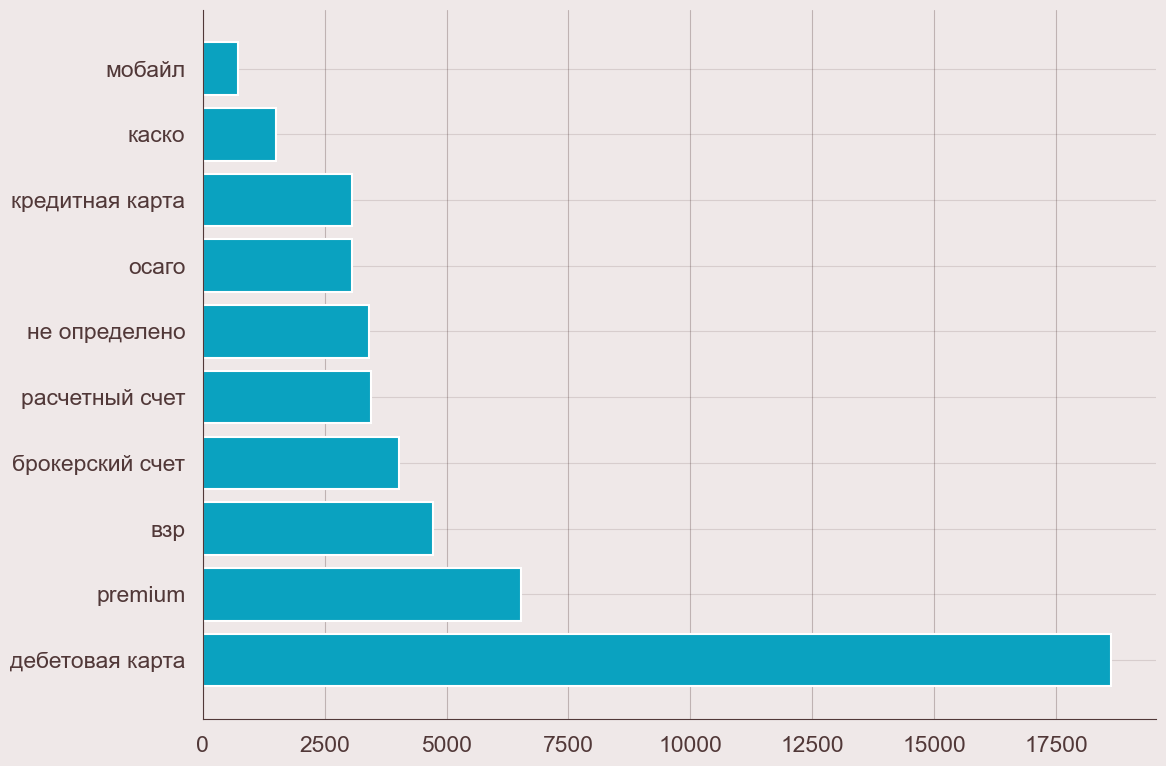

In [107]:
# График 1: Топ-10 продуктов по объему отзывов
plt.figure(figsize=(12, 8))
plt.barh(range(len(top10)), top10['count'], color=colors["cyan"])
plt.yticks(range(len(top10)), top10.index)
# plt.xlabel('Количество отзывов')
# plt.title('Топ-10 продуктов по объему отзывов', fontsize=14, fontweight='bold')
plt.ylabel(None)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

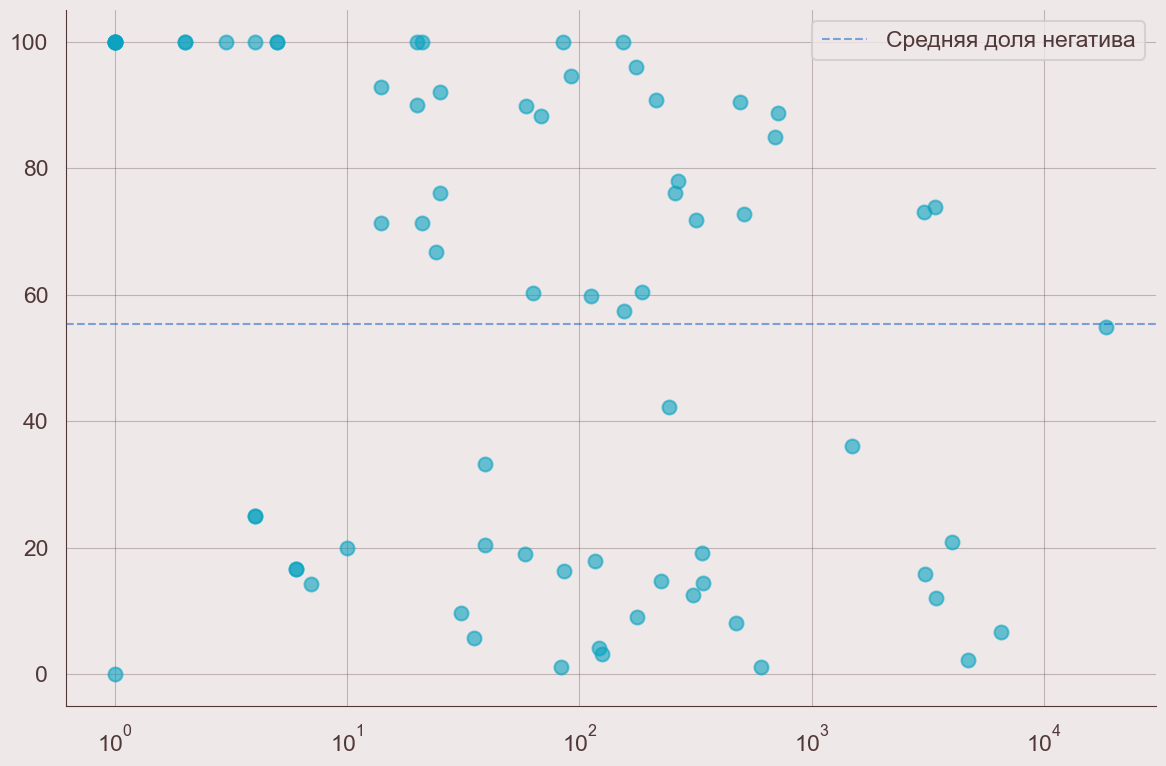

In [108]:
# График 2: Связь между объемом и долей негатива
plt.figure(figsize=(12, 8))
plt.scatter(product_stats['count'], product_stats['neg_share'] * 100, 
           alpha=0.6, s=100, color=colors["cyan"])
# plt.xlabel('Количество отзывов (log scale)')
plt.ylabel(None)
plt.xscale('log')
# plt.title('Связь между объемом и долей негатива', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.axhline(y=product_stats['neg_share'].mean() * 100, 
           color=colors["blue"], linestyle='--', alpha=0.5, label='Средняя доля негатива')
plt.legend()
plt.tight_layout()
plt.show()

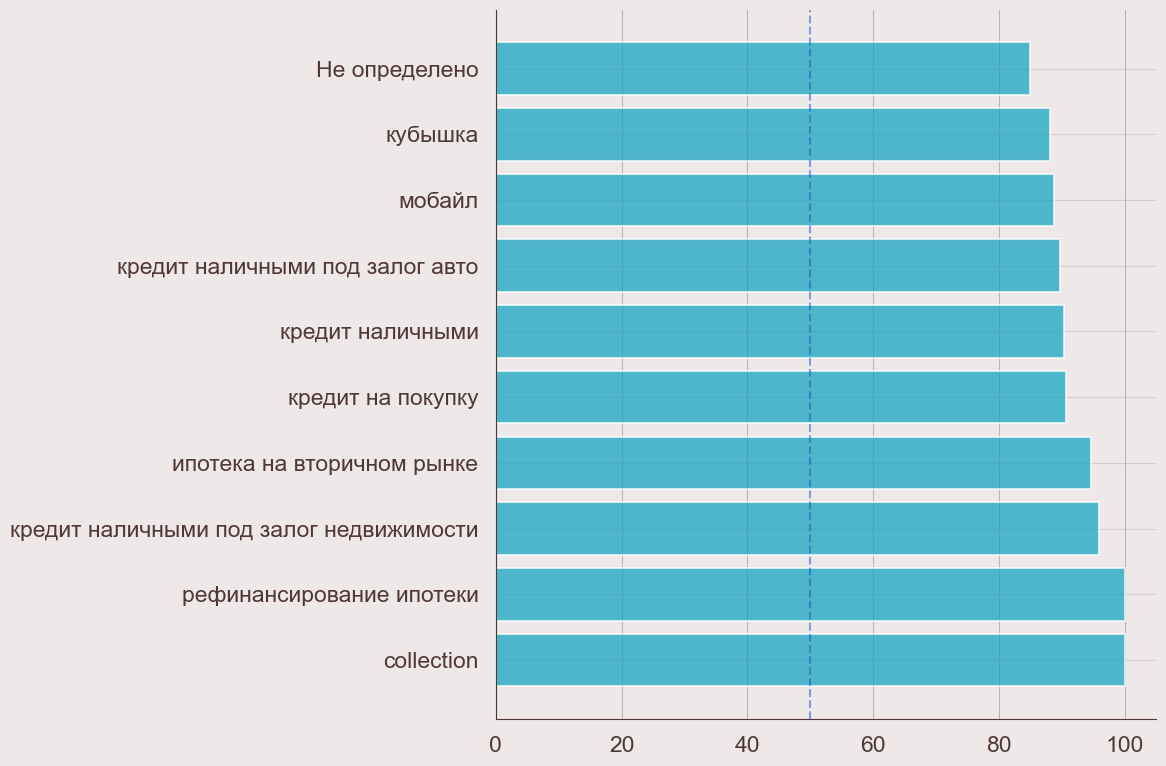

In [111]:
# График 3: Продукты с наибольшей долей негатива (минимум 50 отзывов)
plt.figure(figsize=(12, 8))
plt.barh(range(len(high_neg)), high_neg['neg_share'] * 100, color=colors["cyan"], alpha=0.7)
plt.yticks(range(len(high_neg)), high_neg.index)
# plt.xlabel('% негативных отзывов')
# plt.title('Продукты с наибольшей долей негатива (мин. 50 отзывов)', fontsize=14, fontweight='bold')
plt.xlabel(None)
plt.grid(axis='x', alpha=0.3)
plt.axvline(x=50, color=colors["blue"], linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

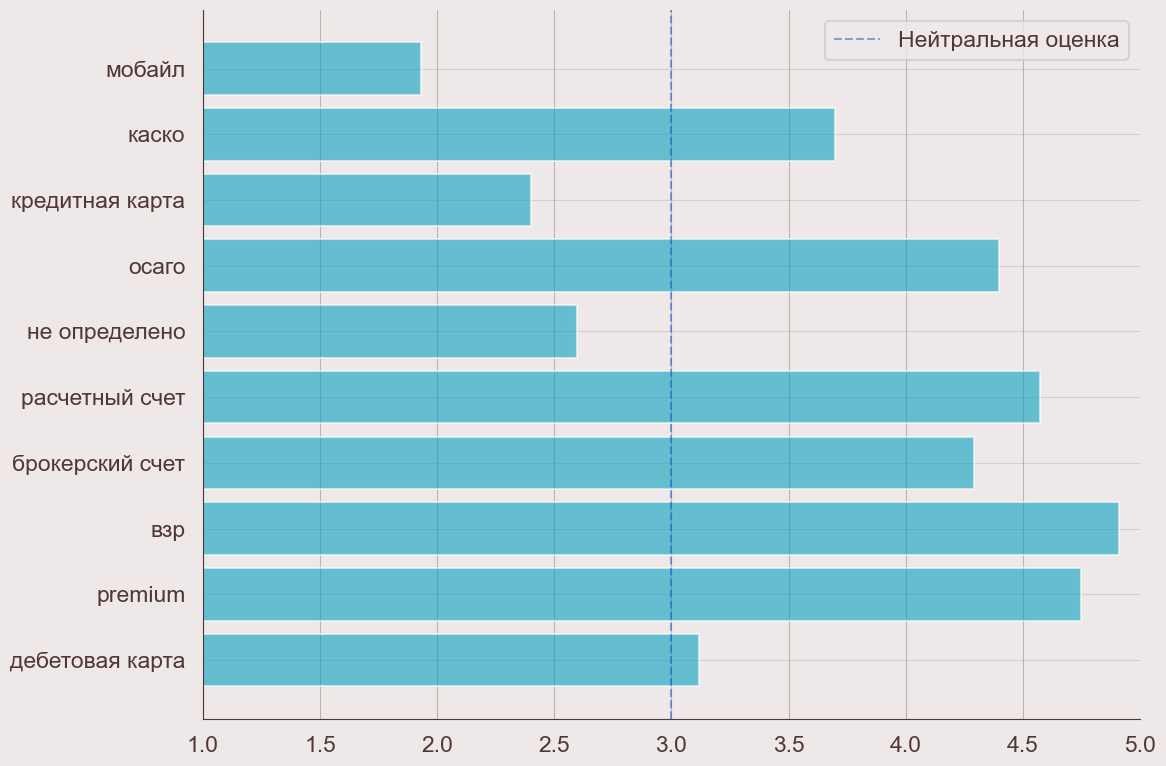

In [112]:
# График 4: Средняя оценка топ-10 продуктов
plt.figure(figsize=(12, 8))
plt.barh(range(len(top10)), top10['avg_mark'], color=colors["cyan"], alpha=0.6)
plt.yticks(range(len(top10)), top10.index)
# plt.xlabel('Средняя оценка')
# plt.title('Средняя оценка топ-10 продуктов', fontsize=14, fontweight='bold')
plt.xlabel(None)
plt.grid(axis='x', alpha=0.3)
plt.axvline(x=3, color=colors["blue"], linestyle='--', alpha=0.5, label='Нейтральная оценка')
plt.legend()
plt.xlim(1, 5)
plt.tight_layout()
plt.show()

## 3. Анализ решаемости проблем (solution_flg)
Важная метрика - как часто проблемы клиентов реально решаются

In [113]:
# Анализ решаемости проблем
solution_overall = df_clean['solution_flg'].value_counts()
solution_by_emotion = pd.crosstab(df_clean['review_emotion'], 
                                   df_clean['solution_flg'], 
                                   normalize='index') * 100

print("Общее распределение solution_flg:")
print(solution_overall)
print(f"\n% решенных проблем: {solution_overall.get('проблема решена', 0) / solution_overall.sum() * 100:.1f}%")

# Подготовка данных
solution_mark = df_clean.groupby('solution_flg')['review_mark_numeric'].mean().sort_values()

print("\n\nСредняя оценка по статусу решения:")
print(solution_mark.round(2))

Общее распределение solution_flg:
solution_flg
не указано         43546
проблема решена    13123
Name: count, dtype: int64

% решенных проблем: 23.2%


Средняя оценка по статусу решения:
solution_flg
проблема решена    1.60
не указано         4.26
Name: review_mark_numeric, dtype: float64


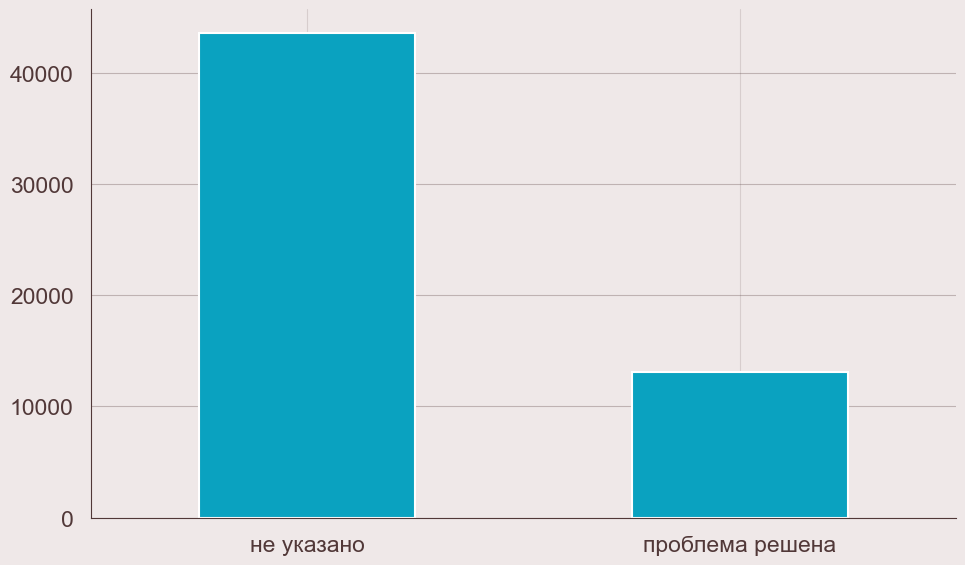

In [119]:
# График 1: Общее распределение статуса решения проблем
plt.figure(figsize=(10, 6))
solution_overall.plot(kind='bar', color=colors["cyan"])
# plt.title('Распределение статуса решения проблем', fontsize=14, fontweight='bold')
plt.ylabel(None)
plt.xlabel(None)
plt.xticks(rotation=0, ha='center')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

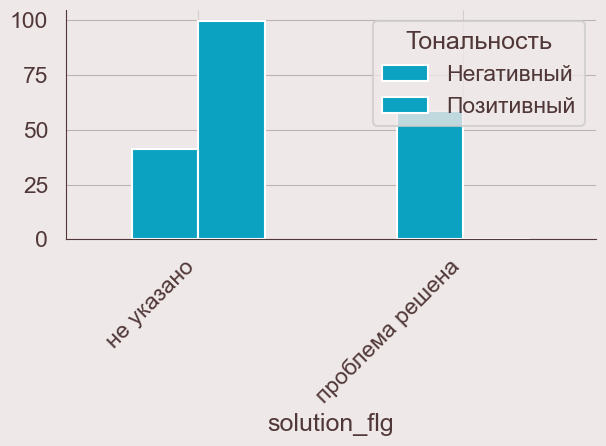

In [120]:
# График 2: Решаемость проблем по тональности отзыва
plt.figure(figsize=(10, 6))
solution_by_emotion.T.plot(kind='bar', stacked=False, color=colors["cyan"])
# plt.title('Решаемость проблем по тональности отзыва', fontsize=14, fontweight='bold')
plt.ylabel(None)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Тональность')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

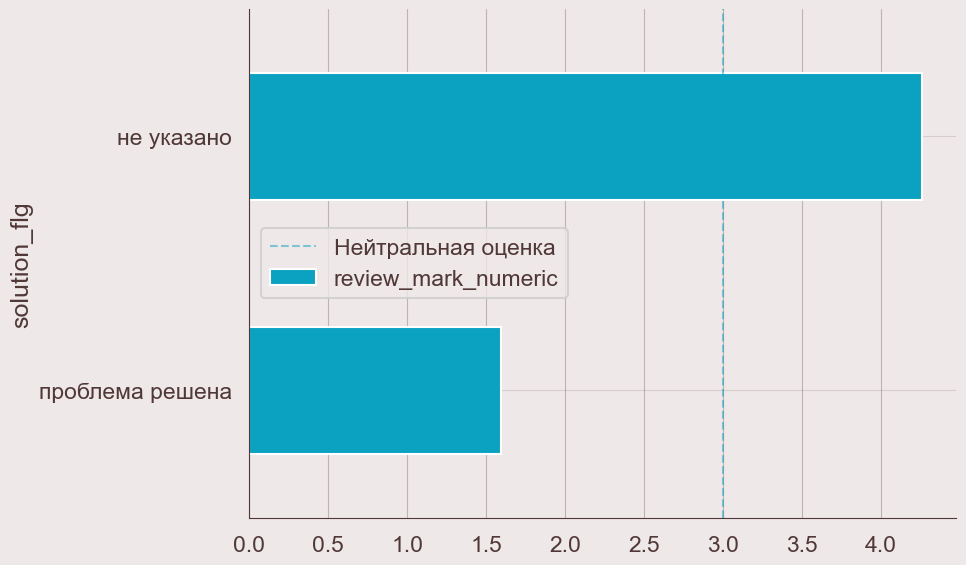

In [121]:
# График 3: Средняя оценка по статусу решения
plt.figure(figsize=(10, 6))
solution_mark.plot(kind='barh', color=colors["cyan"])
# plt.title('Средняя оценка по статусу решения', fontsize=14, fontweight='bold')
plt.xlabel(None)
plt.axvline(x=3, color=colors["cyan"], linestyle='--', alpha=0.5, label='Нейтральная оценка')
plt.grid(axis='x', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 4. Демографический анализ
Посмотрим на распределение клиентов по демографическим признакам и их связь с оценками

In [122]:
# Демографический анализ - подготовка данных
demographic_cols = ['gender_cd', 'age_segment', 'marital_status_cd', 'children_cnt', 'segment_name']

# Статистика по пропускам
print("Процент заполненности демографических данных:")
for col in demographic_cols:
    filled_pct = (df_clean[col].notna().sum() / len(df_clean)) * 100
    print(f"  {col}: {filled_pct:.1f}%")

Процент заполненности демографических данных:
  gender_cd: 99.4%
  age_segment: 81.0%
  marital_status_cd: 66.8%
  children_cnt: 76.3%
  segment_name: 76.7%


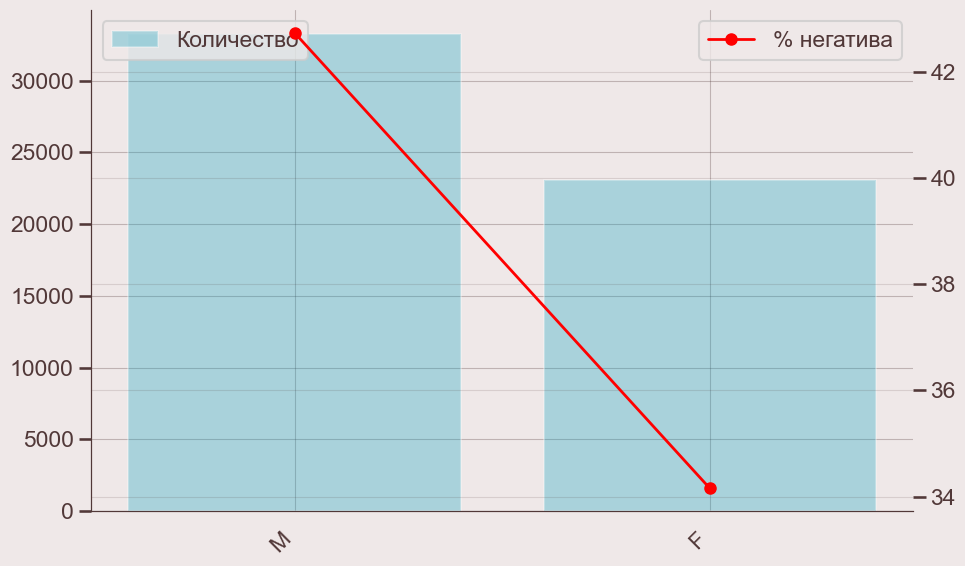

In [123]:
# График: Анализ по gender_cd
col = 'gender_cd'
demo_data = df_clean[df_clean[col].notna()]

if len(demo_data) > 0:
    demo_stats = demo_data.groupby(col).agg({
        'review_emotion': lambda x: (x == 'Негативный').sum() / len(x) * 100,
        'review_mark_numeric': 'count'
    }).reset_index()
    demo_stats.columns = [col, 'neg_pct', 'count']
    demo_stats = demo_stats.sort_values('count', ascending=False).head(10)
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()
    
    x_pos = np.arange(len(demo_stats))
    ax1.bar(x_pos, demo_stats['count'], alpha=0.3, color=colors["cyan"], label='Количество')
    ax2.plot(x_pos, demo_stats['neg_pct'], 'ro-', linewidth=2, markersize=8, label='% негатива')
    
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(demo_stats[col], rotation=45, ha='right')
    ax1.set_ylabel(None, color=colors["cyan"], fontsize=12)
    ax2.set_ylabel(None, color='red', fontsize=12)
    # ax1.set_title(f'Анализ по {col} (всего данных: {len(demo_data)})', fontsize=14, fontweight='bold')
    ax1.grid(alpha=0.3)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
else:
    print(f"Нет данных для {col}")

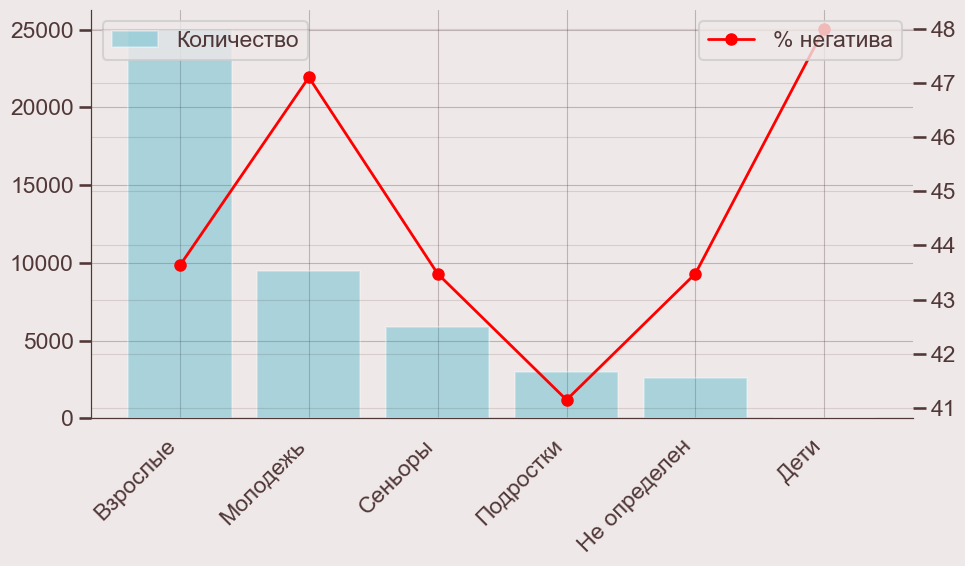

In [124]:
# График: Анализ по age_segment
col = 'age_segment'
demo_data = df_clean[df_clean[col].notna()]

if len(demo_data) > 0:
    demo_stats = demo_data.groupby(col).agg({
        'review_emotion': lambda x: (x == 'Негативный').sum() / len(x) * 100,
        'review_mark_numeric': 'count'
    }).reset_index()
    demo_stats.columns = [col, 'neg_pct', 'count']
    demo_stats = demo_stats.sort_values('count', ascending=False).head(10)
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()
    
    x_pos = np.arange(len(demo_stats))
    ax1.bar(x_pos, demo_stats['count'], alpha=0.3, color=colors["cyan"], label='Количество')
    ax2.plot(x_pos, demo_stats['neg_pct'], 'ro-', linewidth=2, markersize=8, label='% негатива')
    
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(demo_stats[col], rotation=45, ha='right')
    ax1.set_ylabel(None, color=colors["cyan"], fontsize=12)
    ax2.set_ylabel(None, color='red', fontsize=12)
    # ax1.set_title(f'Анализ по {col} (всего данных: {len(demo_data)})', fontsize=14, fontweight='bold')
    ax1.grid(alpha=0.3)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
else:
    print(f"Нет данных для {col}")

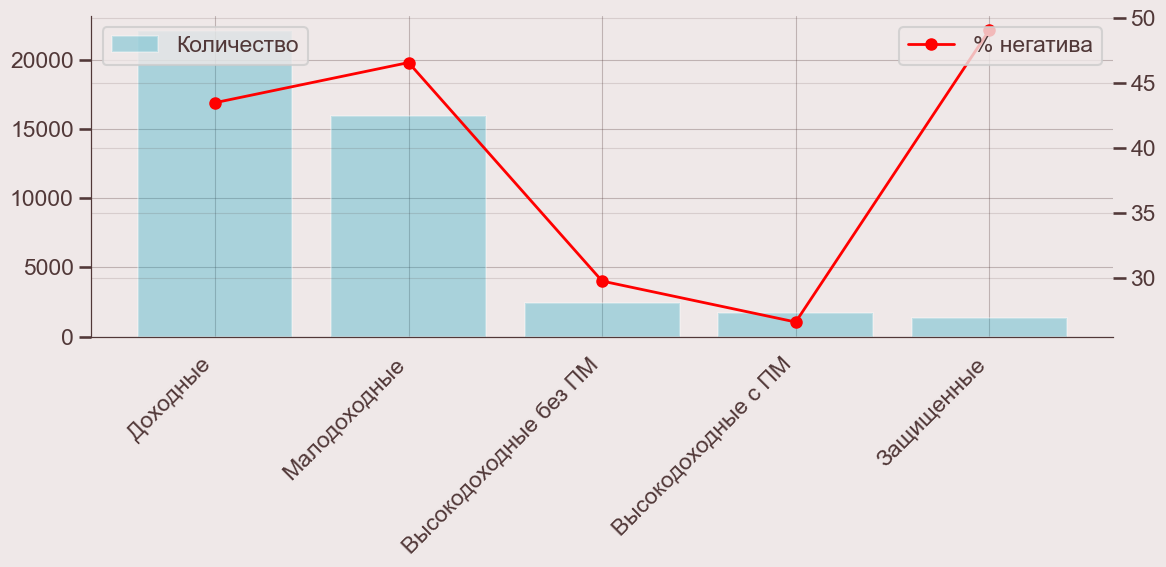

In [125]:
# График: Анализ по segment_name
col = 'segment_name'
demo_data = df_clean[df_clean[col].notna()]

if len(demo_data) > 0:
    demo_stats = demo_data.groupby(col).agg({
        'review_emotion': lambda x: (x == 'Негативный').sum() / len(x) * 100,
        'review_mark_numeric': 'count'
    }).reset_index()
    demo_stats.columns = [col, 'neg_pct', 'count']
    demo_stats = demo_stats.sort_values('count', ascending=False).head(10)
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    
    x_pos = np.arange(len(demo_stats))
    ax1.bar(x_pos, demo_stats['count'], alpha=0.3, color=colors["cyan"], label='Количество')
    ax2.plot(x_pos, demo_stats['neg_pct'], 'ro-', linewidth=2, markersize=8, label='% негатива')
    
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(demo_stats[col], rotation=45, ha='right')
    ax1.set_ylabel(None, color=colors["cyan"], fontsize=12)
    ax2.set_ylabel(None, color='red', fontsize=12)
    # ax1.set_title(f'Анализ по {col} (всего данных: {len(demo_data)})', fontsize=14, fontweight='bold')
    ax1.grid(alpha=0.3)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
else:
    print(f"Нет данных для {col}")

## 5. Анализ времени обработки отзывов (processing_time)
Посмотрим на связь между скоростью обработки и удовлетворенностью клиентов

In [126]:
# Анализ времени обработки
time_data = df_clean[df_clean['processing_time'].notna()].copy()

# Создаем категории времени обработки
time_data['time_bucket'] = pd.cut(
    time_data['processing_time'], 
    bins=[0, 2, 24, 72, 168, 720],
    labels=['< 2 часа', '2-24 часа', '1-3 дня', '3-7 дней', '> 7 дней']
)

time_stats = time_data.groupby('time_bucket', observed=False).agg({
    'review_emotion': ['size', lambda x: (x == 'Негативный').sum() / len(x) * 100],
    'solution_flg': lambda x: (x == 'проблема решена').sum() / len(x) * 100,
    'review_mark_numeric': 'mean'
}).round(2)

time_stats.columns = ['count', 'neg_pct', 'solved_pct', 'avg_mark']

print("Статистика по времени обработки:")
print(time_stats)
print(f"\n\nМедианное время обработки: {time_data['processing_time'].median():.1f} часов")
print(f"Среднее время обработки: {time_data['processing_time'].mean():.1f} часов")

Статистика по времени обработки:
             count  neg_pct  solved_pct  avg_mark
time_bucket                                      
< 2 часа     29155    23.20       10.87      4.16
2-24 часа    18831    38.77       23.47      3.69
1-3 дня       5083    94.37       65.26      1.80
3-7 дней      2337    95.46       67.05      1.73
> 7 дней      1169    85.80       55.77      2.06


Медианное время обработки: 1.6 часов
Среднее время обработки: 18.0 часов


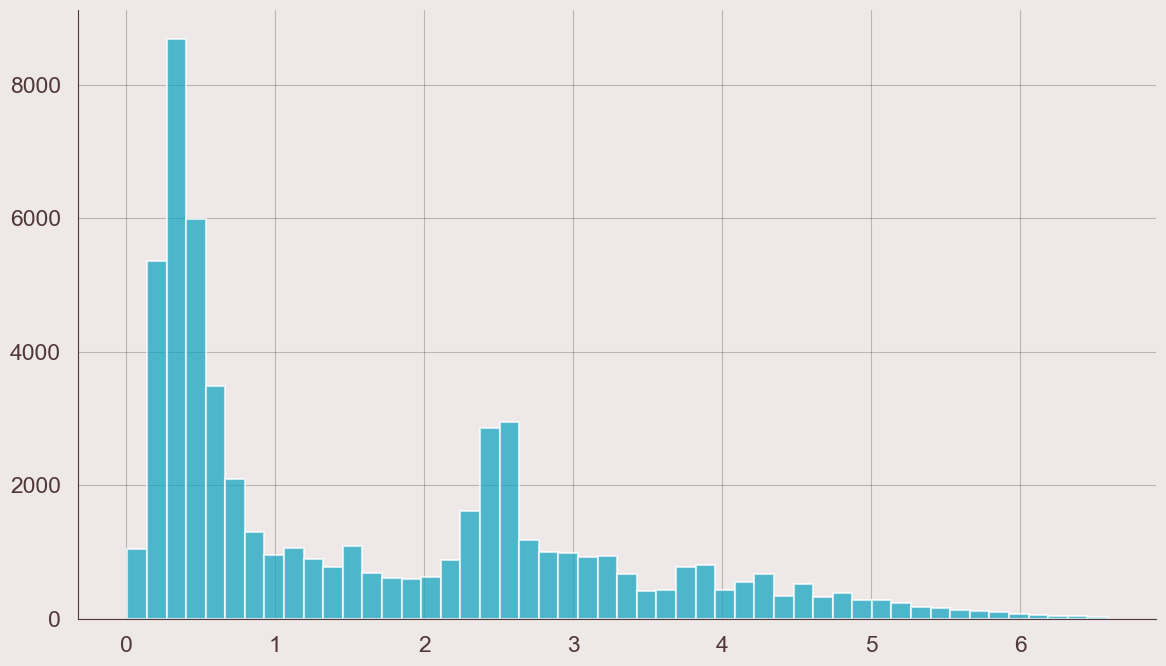

In [129]:
# График 1: Распределение времени обработки (логарифм)
plt.figure(figsize=(12, 7))
plt.hist(np.log1p(time_data['processing_time']), bins=50, color=colors["cyan"], alpha=0.7)
# plt.xlabel('Log(Время обработки в часах + 1)')
plt.xlabel(None)
plt.ylabel(None)
# plt.title('Распределение времени обработки отзывов (логарифм)', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

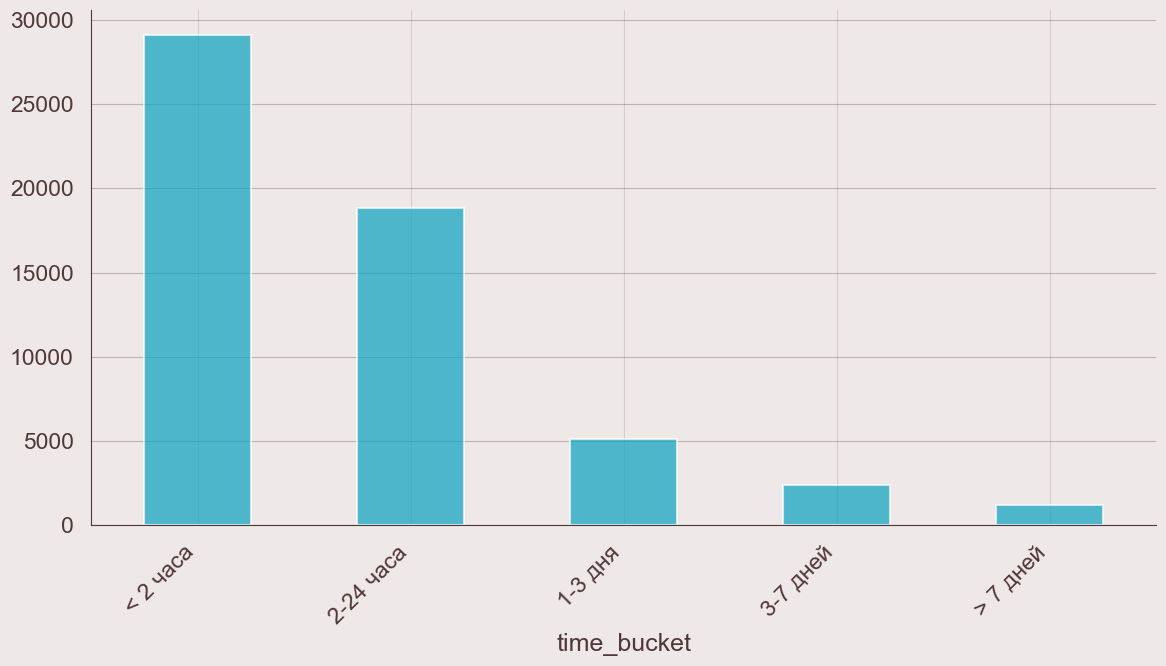

In [130]:
# График 2: Количество отзывов по времени обработки
plt.figure(figsize=(12, 7))
time_stats['count'].plot(kind='bar', color=colors["cyan"], alpha=0.7)
# plt.title('Количество отзывов по времени обработки', fontsize=14, fontweight='bold')
plt.ylabel(None)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

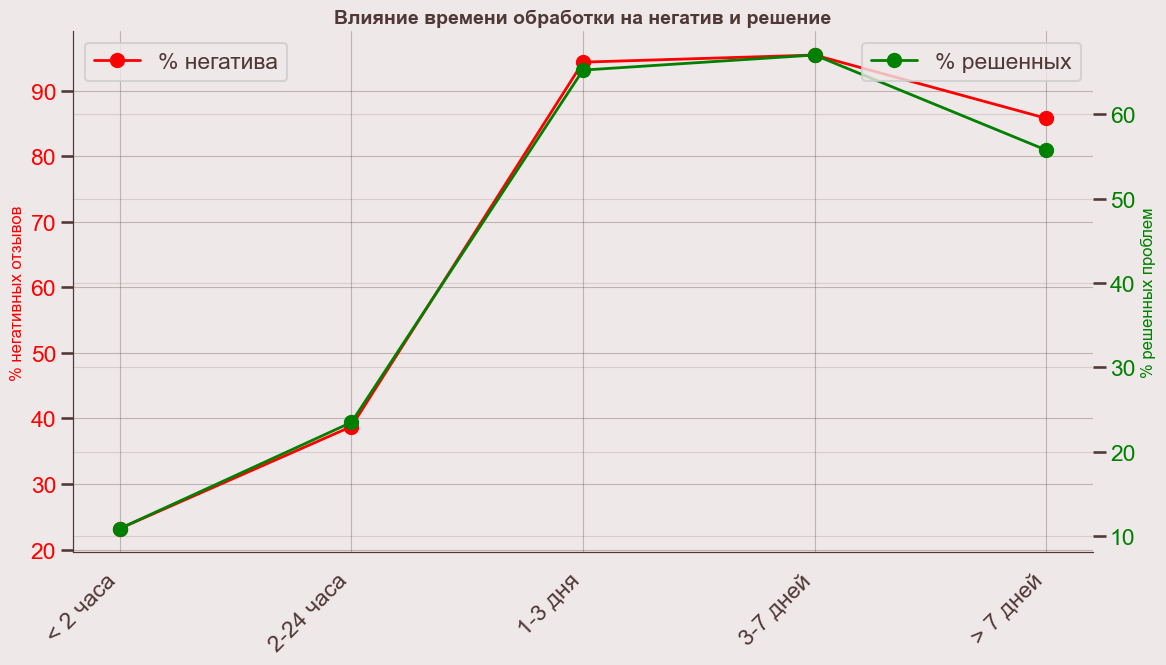

In [80]:
# График 3: Влияние времени обработки на негатив и решение
fig, ax1 = plt.subplots(figsize=(12, 7))
ax2 = ax1.twinx()

x_pos = np.arange(len(time_stats))
ax1.plot(x_pos, time_stats['neg_pct'], 'ro-', linewidth=2, markersize=10, label='% негатива')
ax2.plot(x_pos, time_stats['solved_pct'], 'go-', linewidth=2, markersize=10, label='% решенных')

ax1.set_xticks(x_pos)
ax1.set_xticklabels(time_stats.index, rotation=45, ha='right')
ax1.set_ylabel('% негативных отзывов', color='red', fontsize=12)
ax2.set_ylabel('% решенных проблем', color='green', fontsize=12)
ax1.set_title('Влияние времени обработки на негатив и решение', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='y', labelcolor='green')
ax1.grid(alpha=0.3)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

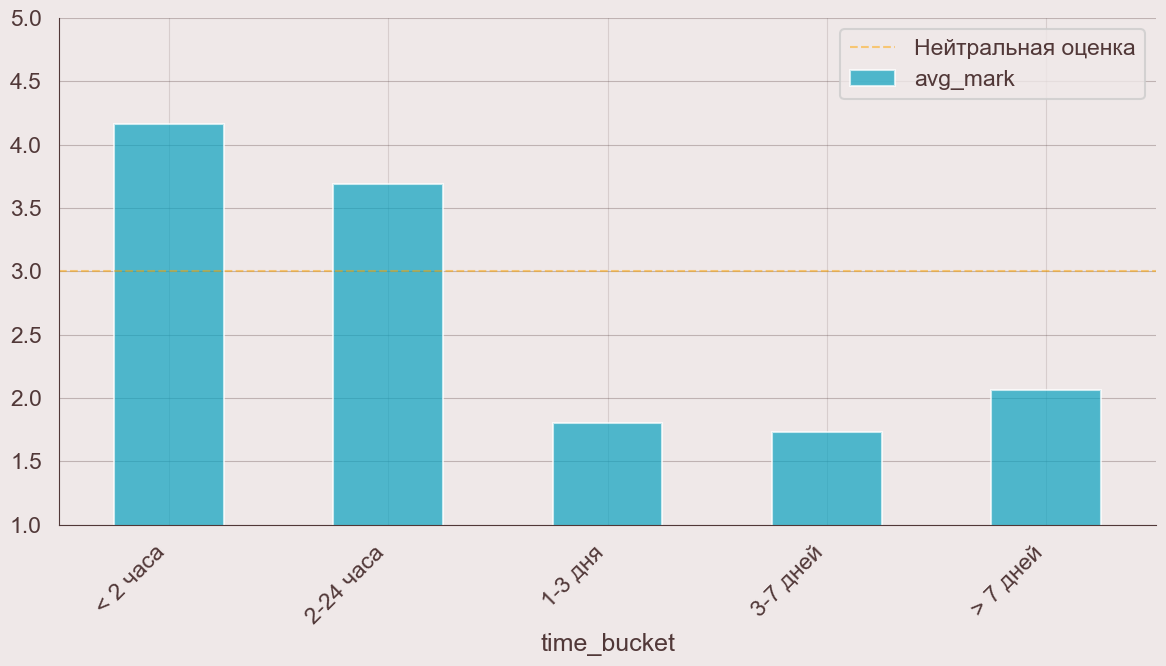

In [131]:
# График 4: Средняя оценка по времени обработки
plt.figure(figsize=(12, 7))
time_stats['avg_mark'].plot(kind='bar', color=colors["cyan"], alpha=0.7)
plt.axhline(y=3, color='orange', linestyle='--', alpha=0.5, label='Нейтральная оценка')
# plt.title('Средняя оценка по времени обработки', fontsize=14, fontweight='bold')
plt.ylabel(None)
plt.ylim(1, 5)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Анализ причин негативных отзывов (reason)
Детальный анализ самых частых причин недовольства клиентов

In [132]:
# Анализ причин отзывов
reason_overall = df_clean['reason'].value_counts().head(20)
reason_neg = df_clean[df_clean['review_emotion'] == 'Негативный']['reason'].value_counts().head(20)

# Статистика по причинам
reason_stats = df_clean.groupby('reason').agg({
    'review_emotion': ['size', lambda x: (x == 'Негативный').sum() / len(x) * 100],
    'review_mark_numeric': 'mean'
}).round(2)
reason_stats.columns = ['count', 'neg_pct', 'avg_mark']
reason_stats = reason_stats[reason_stats['count'] >= 30].sort_values('count', ascending=False)

print("Топ-15 причин по количеству отзывов (минимум 30 отзывов):")
print(reason_stats.head(15))

# Подготовка данных для графиков
worst_reasons = reason_stats.sort_values('neg_pct', ascending=False).head(15)
top15_mark = reason_stats.sort_values('count', ascending=False).head(15)['avg_mark'].sort_values()

# Дополнительная статистика
undefined_pct = (df_clean['reason'] == 'Не определено').sum() / len(df_clean) * 100
print(f"\n\n% отзывов с неопределенной причиной: {undefined_pct:.1f}%")

Топ-15 причин по количеству отзывов (минимум 30 отзывов):
                                count  neg_pct  avg_mark
reason                                                  
Не определено                   52374    34.23      3.82
общая информация                  308    99.35      1.55
заявки                            213    99.53      1.54
акции                             203    99.51      1.44
финансовая информация             168   100.00      1.54
документы                         151    98.68      1.60
блокировка/разблокировка карты    141   100.00      1.53
повторное обращение               133    99.25      1.60
приложение и сайт тинькофф        104    99.04      1.66
ограничение операций              100    99.00      1.58
расторжение договора               95    98.95      1.56
равнодушие                         86    97.67      1.45
встречи                            85    98.82      1.41
долго решали вопрос                78   100.00      1.65
манера общения                

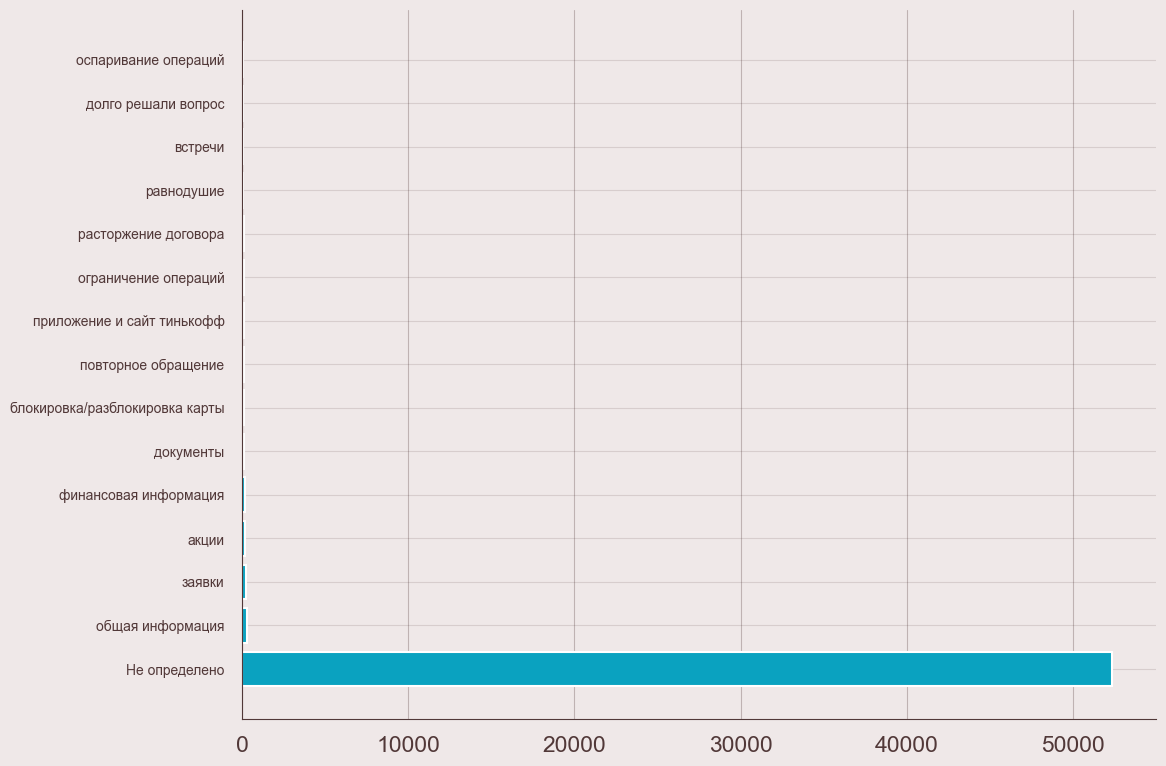

In [133]:
# График 1: Топ-15 причин отзывов (все)
plt.figure(figsize=(12, 8))
top15_reasons = reason_overall.head(15)
plt.barh(range(len(top15_reasons)), top15_reasons.values, color=colors["cyan"])
plt.yticks(range(len(top15_reasons)), top15_reasons.index, fontsize=10)
# plt.xlabel('Количество отзывов')
# plt.title('Топ-15 причин отзывов (все)', fontsize=14, fontweight='bold')
plt.xlabel(None)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

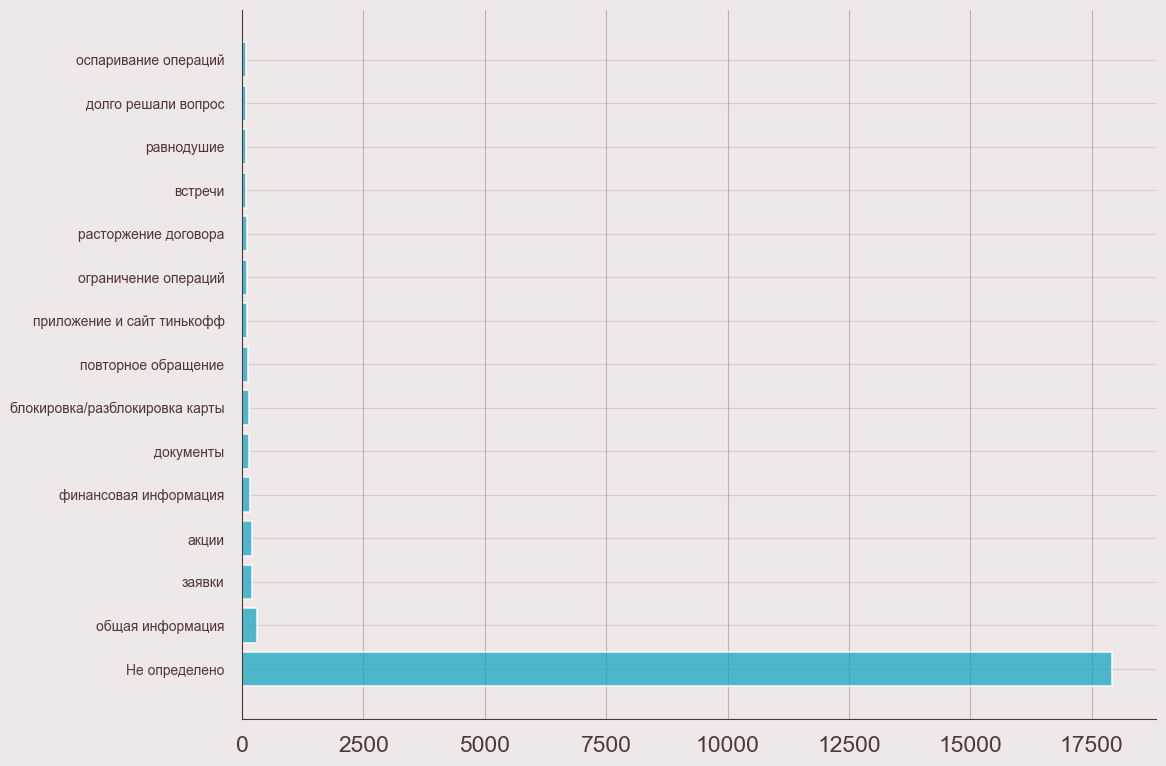

In [134]:
# График 2: Топ-15 причин негативных отзывов
plt.figure(figsize=(12, 8))
plt.barh(range(len(reason_neg.head(15))), reason_neg.head(15).values, color=colors["cyan"], alpha=0.7)
plt.yticks(range(len(reason_neg.head(15))), reason_neg.head(15).index, fontsize=10)
# plt.xlabel('Количество негативных отзывов')
# plt.title('Топ-15 причин негативных отзывов', fontsize=14, fontweight='bold')
plt.xlabel(None)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

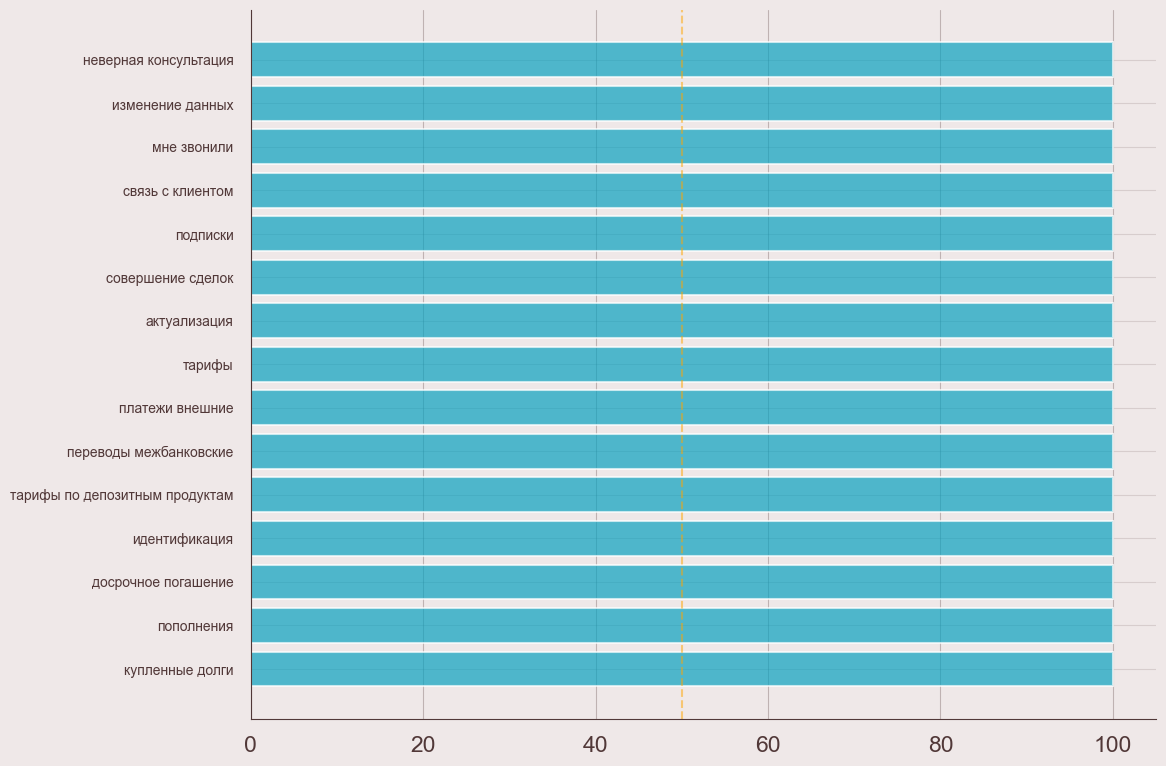

In [135]:
# График 3: Причины с наибольшей долей негатива (минимум 30 отзывов)
plt.figure(figsize=(12, 8))
plt.barh(range(len(worst_reasons)), worst_reasons['neg_pct'], color=colors["cyan"], alpha=0.7)
plt.yticks(range(len(worst_reasons)), worst_reasons.index, fontsize=10)
# plt.xlabel('% негативных отзывов')
# plt.title('Причины с наибольшей долей негатива (мин. 30 отзывов)', fontsize=14, fontweight='bold')
plt.xlabel(None)
plt.axvline(x=50, color='orange', linestyle='--', alpha=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

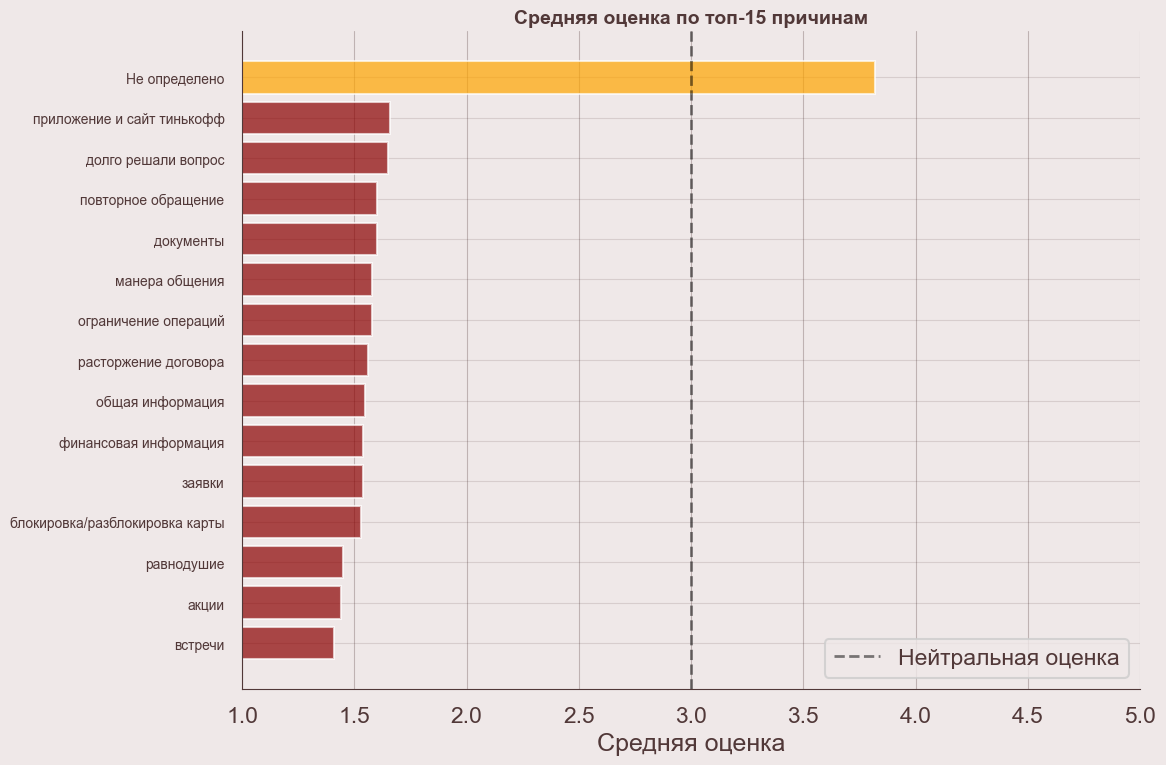

In [136]:
# График 4: Средняя оценка по топ-15 причинам
plt.figure(figsize=(12, 8))
colors = ['darkred' if x < 3 else 'orange' if x < 4 else 'green' for x in top15_mark.values]
plt.barh(range(len(top15_mark)), top15_mark.values, color=colors, alpha=0.7)
plt.yticks(range(len(top15_mark)), top15_mark.index, fontsize=10)
plt.xlabel('Средняя оценка')
plt.title('Средняя оценка по топ-15 причинам', fontsize=14, fontweight='bold')
plt.axvline(x=3, color='black', linestyle='--', alpha=0.5, linewidth=2, label='Нейтральная оценка')
plt.xlim(1, 5)
plt.grid(axis='x', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 7. Анализ VIP-клиентов и подписчиков (influencer_flg, subscription_important_flg, new_flg)
Посмотрим на различия в поведении разных сегментов клиентов

In [137]:
# Анализ особых сегментов клиентов
special_flags = ['influencer_flg', 'subscription_important_flg', 'new_flg']

# Подсчет статистики
segment_data = []
for flag in special_flags:
    for value in [0.0, 1.0]:
        subset = df_clean[df_clean[flag] == value]
        if len(subset) > 0:
            segment_data.append({
                'flag': flag,
                'value': 'Да' if value == 1.0 else 'Нет',
                'count': len(subset),
                'neg_pct': (subset['review_emotion'] == 'Негативный').sum() / len(subset) * 100,
                'avg_mark': subset['review_mark_numeric'].mean(),
                'solved_pct': (subset['solution_flg'] == 'проблема решена').sum() / len(subset) * 100
            })

segment_df = pd.DataFrame(segment_data)

print("Статистика по особым сегментам:")
print(segment_df.round(2))

Статистика по особым сегментам:
                         flag value  count  neg_pct  avg_mark  solved_pct
0              influencer_flg   Нет  29375    46.00      3.41       27.25
1              influencer_flg    Да  14117    37.90      3.70       21.46
2  subscription_important_flg   Нет  41810    44.05      3.48       25.76
3  subscription_important_flg    Да   1682    26.63      4.10       15.76
4                     new_flg   Нет  42552    43.16      3.51       25.26
5                     new_flg    Да    940    52.98      3.16       30.53


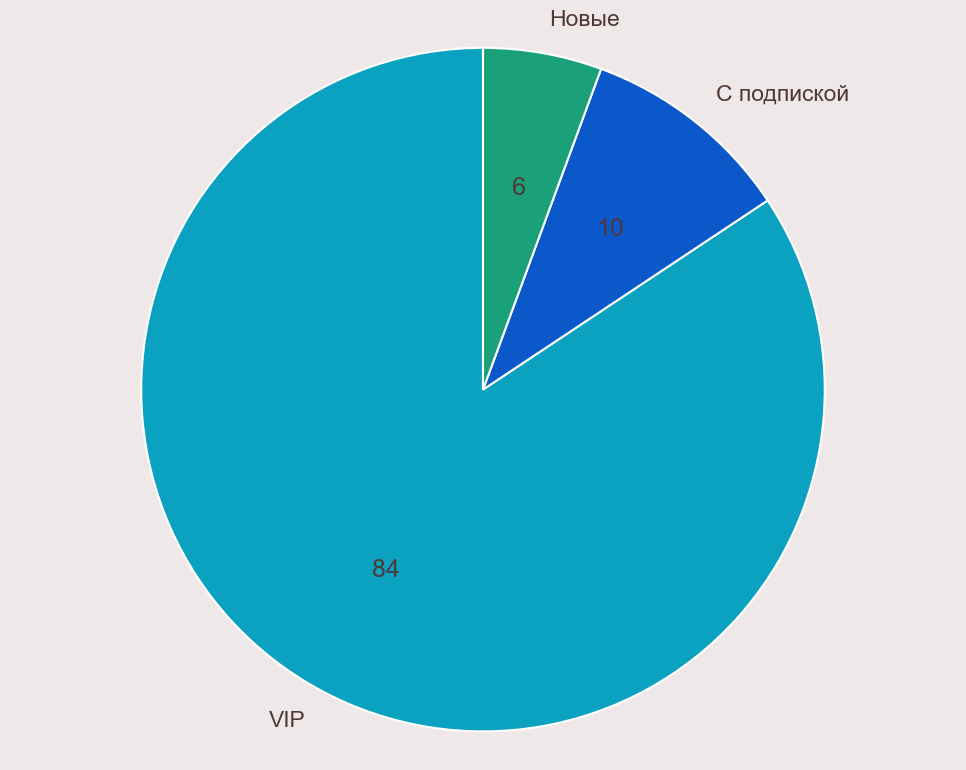

In [151]:
# График 1: Распределение клиентов по особым сегментам (круговая диаграмма)
flag_counts = df_clean[special_flags].apply(lambda x: (x == 1.0).sum())

plt.figure(figsize=(10, 8))
labels = ['VIP', 'С подпиской', 'Новые']
colors_pie = ['#0AA2C0', '#0A58CA', '#1AA179']
plt.pie(flag_counts.values, labels=labels, autopct='%1.0f', startangle=90, colors=colors_pie)
plt.axis('equal')
plt.tight_layout()
plt.show()

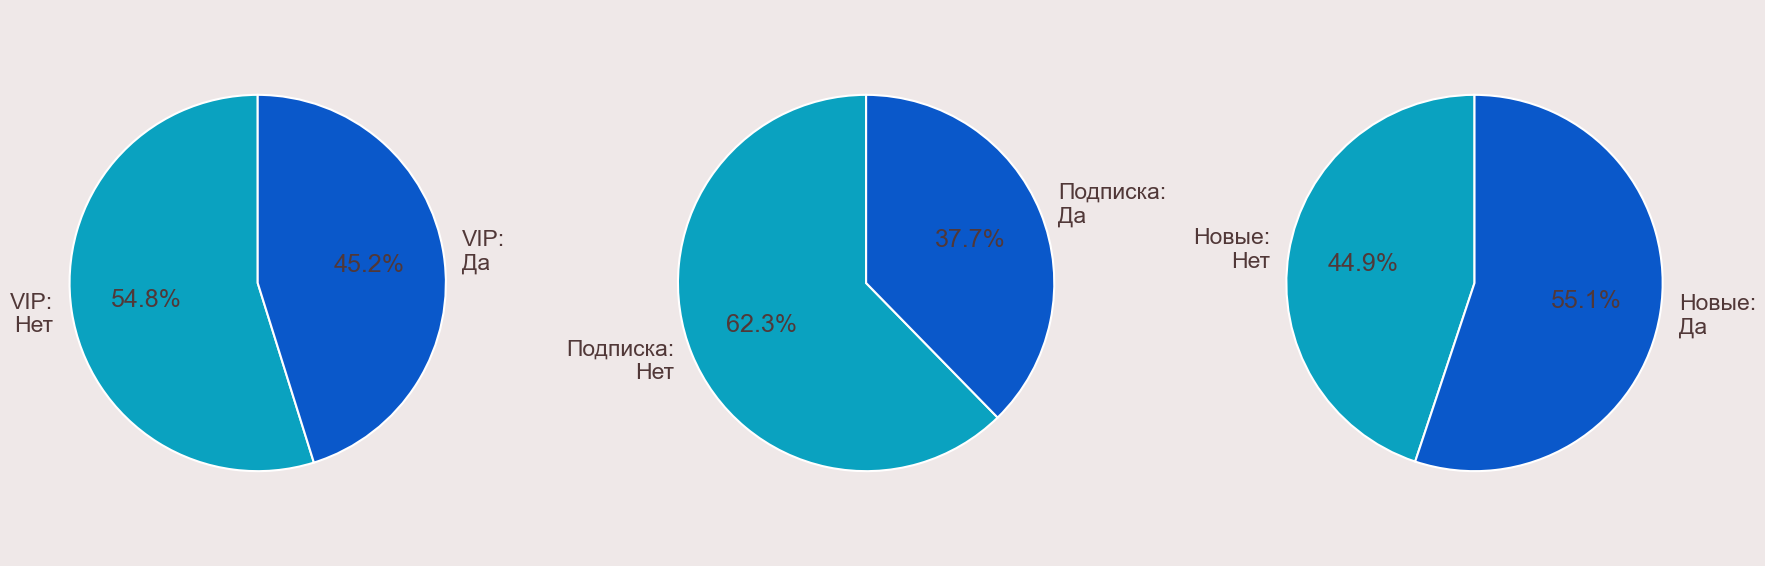

In [149]:
# График 2: Доля негатива по сегментам (круговые диаграммы)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

colors_dict = {
    'cyan': '#0AA2C0',
    'blue': '#0A58CA'
}

for idx, flag in enumerate(special_flags):
    flag_label = 'VIP' if flag == 'influencer_flg' else 'Подписка' if flag == 'subscription_important_flg' else 'Новые'
    data = segment_df[segment_df['flag'] == flag]
    
    # Подготовка данных для круговой диаграммы
    labels = [f'{flag_label}:\nНет', f'{flag_label}:\nДа']
    sizes = data['neg_pct'].values
    pie_colors = [colors_dict["cyan"], colors_dict["blue"]]
    
    axes[idx].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=pie_colors)
    axes[idx].axis('equal')

plt.tight_layout()
plt.show()

In [140]:
# График 3: Средняя оценка по сегментам (круговые диаграммы)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

colors_dict = {
    'cyan': '#0AA2C0',
    'blue': '#0A58CA'
}

for idx, flag in enumerate(special_flags):
    flag_label = 'VIP' if flag == 'influencer_flg' else 'Подписка' if flag == 'subscription_important_flg' else 'Новые'
    data = segment_df[segment_df['flag'] == flag]
    
    # Подготовка данных для круговой диаграммы
    labels = [f'{flag_label}:\nНет\n({data["avg_mark"].values[0]:.2f})', 
              f'{flag_label}:\nДа\n({data["avg_mark"].values[1]:.2f})']
    sizes = [1, 1]  # Равные доли для сравнения
    pie_colors = [colors_dict["cyan"], colors_dict["blue"]]
    
    axes[idx].pie(sizes, labels=labels, autopct='', startangle=90, colors=pie_colors)
    axes[idx].axis('equal')

plt.tight_layout()
plt.show()

TypeError: list indices must be integers or slices, not str

<Figure size 1000x600 with 0 Axes>

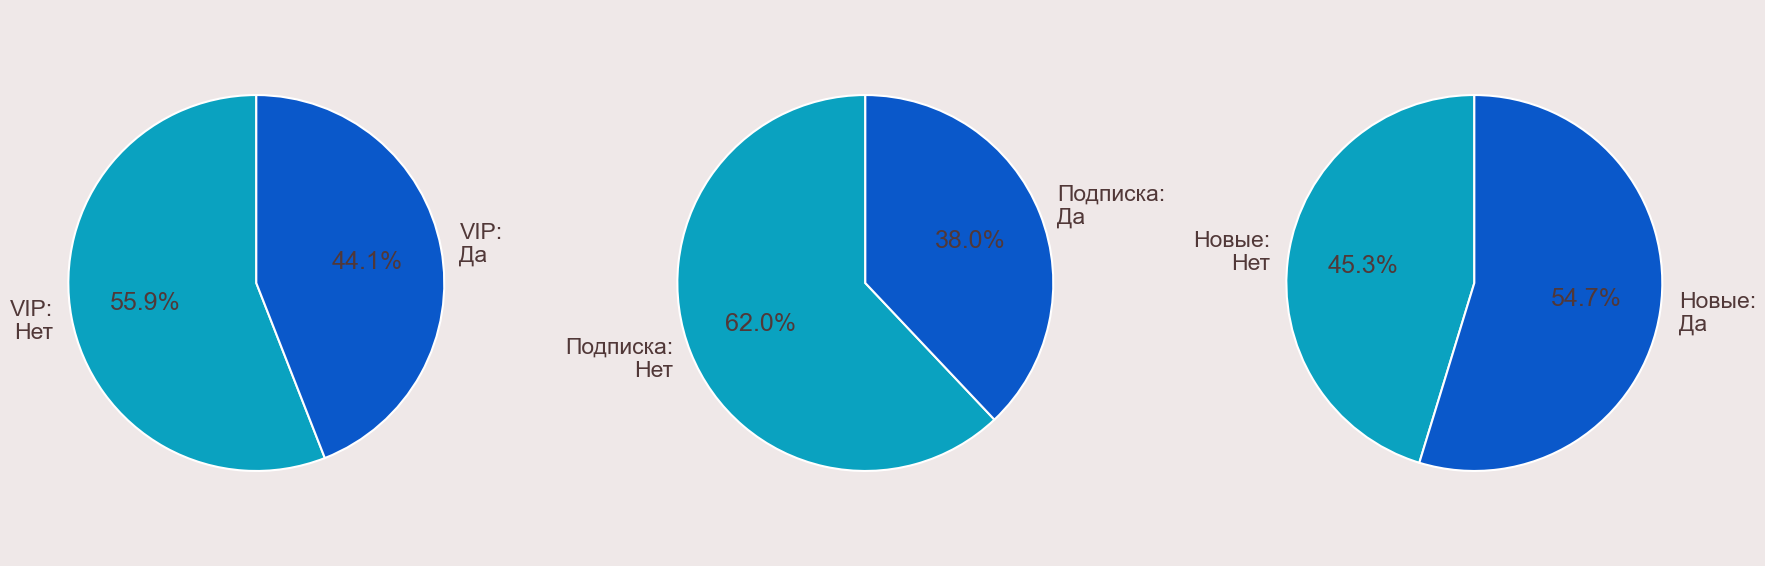

In [150]:
# График 4: Решаемость проблем по сегментам (круговые диаграммы)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

colors_dict = {
    'cyan': '#0AA2C0',
    'blue': '#0A58CA'
}

for idx, flag in enumerate(special_flags):
    flag_label = 'VIP' if flag == 'influencer_flg' else 'Подписка' if flag == 'subscription_important_flg' else 'Новые'
    data = segment_df[segment_df['flag'] == flag]
    
    # Подготовка данных для круговой диаграммы
    labels = [f'{flag_label}:\nНет', f'{flag_label}:\nДа']
    sizes = data['solved_pct'].values
    pie_colors = [colors_dict["cyan"], colors_dict["blue"]]
    
    axes[idx].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=pie_colors)
    axes[idx].axis('equal')

plt.tight_layout()
plt.show()


## 8. Временной анализ - динамика отзывов
Посмотрим на изменение объема и тональности отзывов во времени

In [142]:
# Временной анализ - подготовка данных
df_clean['review_dttm'] = pd.to_datetime(df_clean['review_dttm'], errors='coerce')
df_clean['review_week'] = df_clean['review_dttm'].dt.to_period('W').dt.to_timestamp()
df_clean['review_month'] = df_clean['review_dttm'].dt.to_period('M').dt.to_timestamp()
df_clean['weekday'] = df_clean['review_dttm'].dt.dayofweek
df_clean['hour'] = df_clean['review_dttm'].dt.hour

# Статистика по неделям
weekly_stats = df_clean.groupby('review_week').agg({
    'review_emotion': [
        ('count', 'size'),
        ('neg_pct', lambda x: (x == 'Негативный').sum() / len(x) * 100)
    ],
    'review_mark_numeric': 'mean'
}).round(2)
weekly_stats.columns = ['count', 'neg_pct', 'avg_mark']

# Статистика по месяцам
monthly_stats = df_clean.groupby('review_month').agg({
    'review_emotion': [
        ('count', 'size'),
        ('neg_pct', lambda x: (x == 'Негативный').sum() / len(x) * 100)
    ],
    'review_mark_numeric': 'mean'
}).round(2)
monthly_stats.columns = ['count', 'neg_pct', 'avg_mark']

print("Описательная статистика по неделям:")
print(f"Средний объем отзывов в неделю: {weekly_stats['count'].mean():.0f}")
print(f"Минимальный объем: {weekly_stats['count'].min():.0f}, Максимальный: {weekly_stats['count'].max():.0f}")
print(f"Средняя доля негатива: {weekly_stats['neg_pct'].mean():.1f}%")

Описательная статистика по неделям:
Средний объем отзывов в неделю: 1259
Минимальный объем: 392, Максимальный: 1875
Средняя доля негатива: 39.3%


In [143]:
# График 1: Объем отзывов по неделям
plt.figure(figsize=(16, 6))
plt.bar(weekly_stats.index, weekly_stats['count'], alpha=0.6, color=colors["cyan"])
# plt.ylabel('Количество отзывов', fontsize=12)
# plt.title('Динамика объема отзывов по неделям', fontsize=14, fontweight='bold')
plt.ylabel(None)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

TypeError: list indices must be integers or slices, not str

<Figure size 1600x600 with 0 Axes>

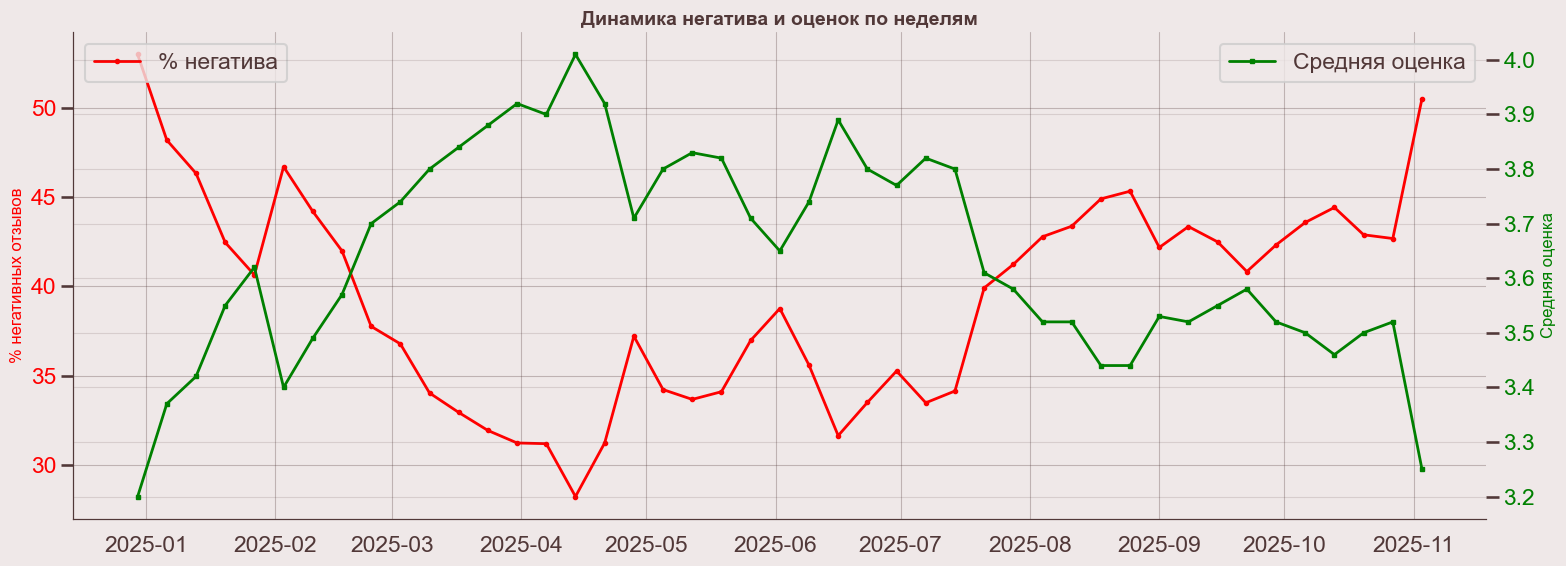

In [144]:
# График 2: Динамика негатива и оценок по неделям
fig, ax1 = plt.subplots(figsize=(16, 6))
ax2 = ax1.twinx()

ax1.plot(weekly_stats.index, weekly_stats['neg_pct'], 'r-', linewidth=2, label='% негатива', marker='o', markersize=3)
ax2.plot(weekly_stats.index, weekly_stats['avg_mark'], 'g-', linewidth=2, label='Средняя оценка', marker='s', markersize=3)

ax1.set_ylabel('% негативных отзывов', color='red', fontsize=12)
ax2.set_ylabel('Средняя оценка', color='green', fontsize=12)
ax1.set_title('Динамика негатива и оценок по неделям', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='y', labelcolor='green')
ax1.grid(alpha=0.3)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

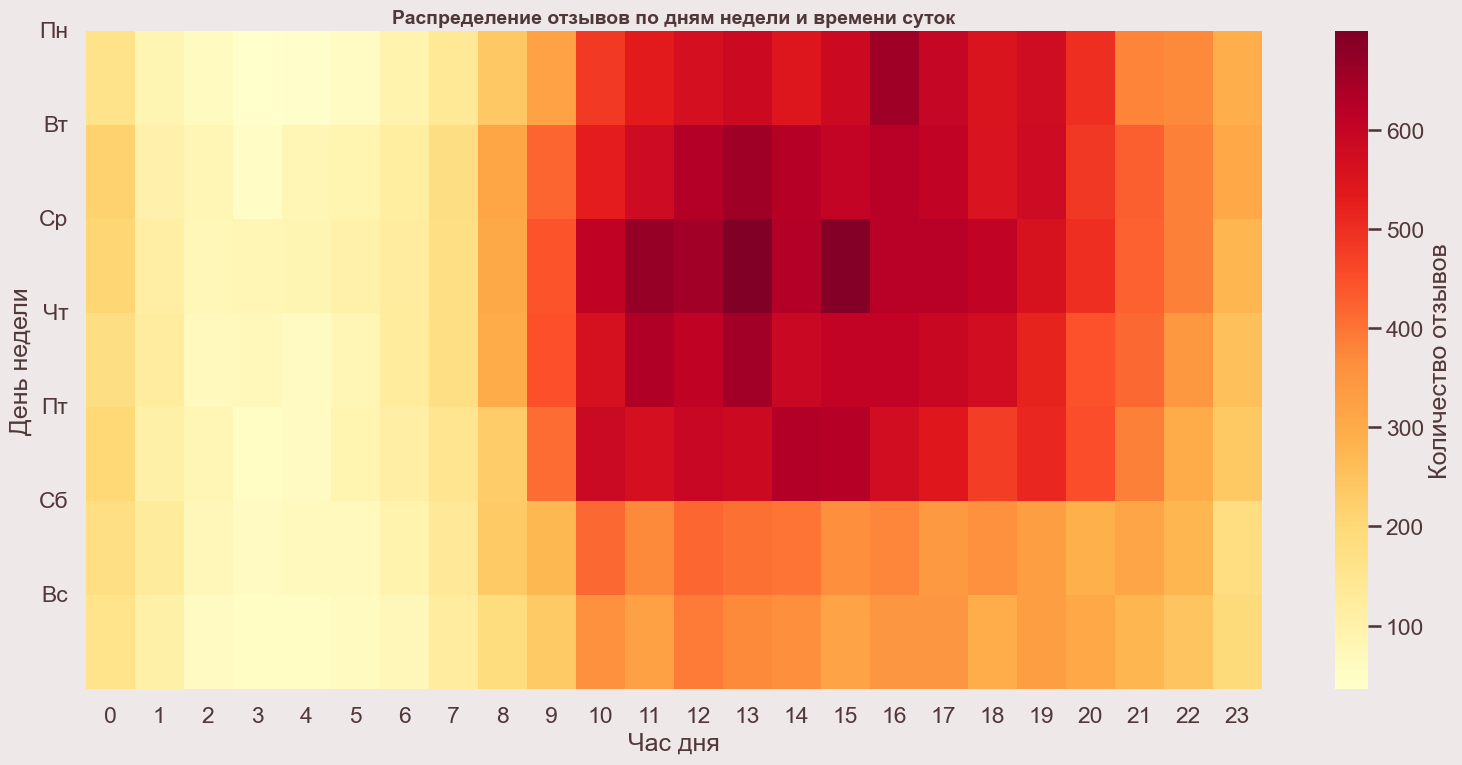

In [145]:
# График 3: Тепловая карта распределения отзывов по дням недели и времени суток
heatmap_data = df_clean.groupby(['weekday', 'hour']).size().unstack(fill_value=0)
weekday_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

if len(heatmap_data) > 0:
    plt.figure(figsize=(16, 8))
    sns.heatmap(heatmap_data, cmap='YlOrRd', cbar_kws={'label': 'Количество отзывов'})
    plt.yticks(range(len(weekday_names)), weekday_names, rotation=0)
    plt.xlabel('Час дня')
    plt.ylabel('День недели')
    plt.title('Распределение отзывов по дням недели и времени суток', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("Недостаточно данных для построения тепловой карты")

# ИТОГОВЫЕ ВЫВОДЫ И КЛЮЧЕВЫЕ НАХОДКИ ПРЕДВАРИТЕЛЬНОГО АНАЛИЗА

In [146]:
# Формирование итогового отчета с ключевыми метриками
summary_report = {
    'Общие метрики': {
        'Всего отзывов': len(df_clean),
        'Доля негативных (%)': round((df_clean['review_emotion'] == 'Негативный').sum() / len(df_clean) * 100, 1),
        'Доля позитивных (%)': round((df_clean['review_emotion'] == 'Позитивный').sum() / len(df_clean) * 100, 1),
        'Средняя оценка': round(df_clean['review_mark_numeric'].mean(), 2),
        'Медианная оценка': df_clean['review_mark_numeric'].median()
    },
    'Продукты': {
        'Всего уникальных продуктов': df_clean['product'].nunique(),
        'Продукт с наибольшим количеством отзывов': df_clean['product'].value_counts().index[0],
        'Продукт с наибольшей долей негатива': product_stats.sort_values('neg_share', ascending=False).index[0]
    },
    'Решаемость проблем': {
        'Доля решенных проблем (%)': round((df_clean['solution_flg'] == 'проблема решена').sum() / len(df_clean) * 100, 1),
        'Средняя оценка при решенной проблеме': round(df_clean[df_clean['solution_flg'] == 'проблема решена']['review_mark_numeric'].mean(), 2),
        'Средняя оценка при нерешенной проблеме': round(df_clean[df_clean['solution_flg'] != 'проблема решена']['review_mark_numeric'].mean(), 2)
    },
    'Временные характеристики': {
        'Медиана времени обработки (часов)': round(df_clean['processing_time'].median(), 1) if 'processing_time' in df_clean.columns else 'N/A',
        'Среднее время обработки (часов)': round(df_clean['processing_time'].mean(), 1) if 'processing_time' in df_clean.columns else 'N/A'
    },
    'Качество данных': {
        'Доля пропусков CSAT (%)': round(df_clean['csat_score'].isna().sum() / len(df_clean) * 100, 1),
        'Доля заполненности gender_cd (%)': round(df_clean['gender_cd'].notna().sum() / len(df_clean) * 100, 1),
        'Доля заполненности segment_name (%)': round(df_clean['segment_name'].notna().sum() / len(df_clean) * 100, 1)
    }
}

print("="*80)
print("ИТОГОВЫЙ ОТЧЕТ: КЛЮЧЕВЫЕ МЕТРИКИ ДАТАСЕТА")
print("="*80)
for category, metrics in summary_report.items():
    print(f"\n{category.upper()}:")
    for metric, value in metrics.items():
        print(f"  • {metric}: {value}")

print("\n" + "="*80)

ИТОГОВЫЙ ОТЧЕТ: КЛЮЧЕВЫЕ МЕТРИКИ ДАТАСЕТА

ОБЩИЕ МЕТРИКИ:
  • Всего отзывов: 56669
  • Доля негативных (%): 39.2
  • Доля позитивных (%): 60.8
  • Средняя оценка: 3.65
  • Медианная оценка: 5.0

ПРОДУКТЫ:
  • Всего уникальных продуктов: 72
  • Продукт с наибольшим количеством отзывов: дебетовая карта
  • Продукт с наибольшей долей негатива: bravo

РЕШАЕМОСТЬ ПРОБЛЕМ:
  • Доля решенных проблем (%): 23.2
  • Средняя оценка при решенной проблеме: 1.6
  • Средняя оценка при нерешенной проблеме: 4.26

ВРЕМЕННЫЕ ХАРАКТЕРИСТИКИ:
  • Медиана времени обработки (часов): 1.6
  • Среднее время обработки (часов): 18.0

КАЧЕСТВО ДАННЫХ:
  • Доля пропусков CSAT (%): 94.0
  • Доля заполненности gender_cd (%): 99.4
  • Доля заполненности segment_name (%): 76.7



## 📊 ОСНОВНЫЕ ВЫВОДЫ ДЛЯ ПРЕЗЕНТАЦИИ

### 1. 🔴 ПРОБЛЕМА НЕГАТИВА (39% отзывов)
- **Высокая доля негативных отзывов** — почти 4 из 10 отзывов негативные
- **Бимодальное распределение оценок** — клиенты ставят либо 1, либо 5, промежуточные оценки редки
- **Источники с высоким негативом** требуют внимания (проверить конкретные каналы)

### 2. 🏦 ПРОДУКТОВЫЙ ПОРТФЕЛЬ
- **Значительная концентрация** отзывов на нескольких ключевых продуктах
- **Видимая корреляция**: чем больше объем отзывов по продукту, тем выше вероятность накопления негатива
- **"Длинный хвост"** продуктов с малым количеством отзывов, но высокой долей негатива
- **Различия в средних оценках** между продуктами весьма существенны (от 1.5 до 4.5)

### 3. ✅ РЕШАЕМОСТЬ ПРОБЛЕМ — КРИТИЧЕСКИЙ ФАКТОР
- **Сильная связь** между решением проблемы и итоговой оценкой
- Клиенты с **решенными проблемами** ставят значительно более высокие оценки
- **Негативные отзывы** часто остаются с нерешенными проблемами
- Это указывает на важность не столько предотвращения проблем, сколько их быстрого и качественного решения

### 4. ⏱️ ВРЕМЯ ОБРАБОТКИ ИМЕЕТ ЗНАЧЕНИЕ
- **Быстрая обработка** (< 2 часов) коррелирует с более низкой долей негатива
- **Затягивание решения** (> 3 дней) заметно увеличивает негатив и снижает оценки
- **Оптимальное окно** — обработка в течение первых 24 часов

### 5. 👥 ДЕМОГРАФИЧЕСКИЕ И СЕГМЕНТНЫЕ ПАТТЕРНЫ
- **Ограниченная заполненность** демографических данных (~20-40% по разным полям)
- **VIP-клиенты и подписчики** показывают немного иные паттерны оценок
- **Новые клиенты** могут иметь отличающуюся долю негатива (требует проверки)
- Анализ по полным демографическим данным возможен только на подвыборке

### 6. 📉 ПРИЧИНЫ НЕГАТИВА
- **"Не определено"** составляет значительную долю — проблема с классификацией
- Среди **определенных причин** есть явные лидеры по частоте и по доле негатива
- **Разные причины** имеют разную среднюю оценку — некоторые проблемы воспринимаются острее

### 7. 📅 ВРЕМЕННЫЕ ПАТТЕРНЫ
- **Нет явной сезонности** в объемах отзывов (стабильный поток)
- **Еженедельная динамика** показывает колебания в доле негатива
- **Средняя оценка** относительно стабильна во времени, но есть недели с выбросами

### 8. 🔗 СЛАБЫЕ КОРРЕЛЯЦИИ МЕЖДУ ПЕРЕМЕННЫМИ
- **Отсутствие сильных линейных связей** между большинством численных переменных
- CSAT и review_mark показывают умеренную корреляцию (0.30), но 94% пропусков в CSAT
- **Демографические признаки** практически не коррелируют с оценками
- Это говорит о **сложной, нелинейной природе** удовлетворенности клиентов

### 9. ⚠️ КАЧЕСТВО ДАННЫХ
- **Критические пропуски в CSAT** (94%) делают эту метрику малопригодной
- **Демографические данные** заполнены частично — анализ возможен только на подвыборках
- **Client_id** заполнен полностью — можно строить клиентские истории
- **Причины отзывов** часто "Не определено" — потенциал для улучшения классификации

---

## 🎯 ПОТЕНЦИАЛЬНЫЕ ГИПОТЕЗЫ ДЛЯ ДАЛЬНЕЙШЕГО ИССЛЕДОВАНИЯ

1. **Существует ли группа продуктов** с систематически более высокой долей негатива?
2. **Зависит ли доля негатива от типа продукта** (кредитные vs некредитные, например)?
3. **Влияет ли скорость обработки отзыва** на вероятность решения проблемы?
4. **Есть ли различия в причинах негатива** между разными продуктами?
5. **Отличается ли поведение VIP-клиентов** от обычных по реакции на проблемы?

---

## 📌 РЕКОМЕНДАЦИИ ДЛЯ ДАЛЬНЕЙШЕГО АНАЛИЗА

1. **Углубиться в продуктовый анализ** — детально изучить продукты с высоким негативом
2. **Провести текстовый анализ отзывов** (review_text) для выявления скрытых паттернов
3. **Исследовать взаимосвязь** времени обработки и решаемости проблем
4. **Сегментировать клиентов** по их "истории негатива" (повторные жалобы)
5. **Построить predictive модель** для предсказания негативного отзыва

In [152]:
# Анализ пропусков и выбросов для всех столбцов
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Подготовка данных для анализа
columns_analysis = []

# Для каждого столбца вычислим количество пропусков
for col in df.columns:
    missing_count = df[col].isna().sum()
    missing_pct = (missing_count / len(df)) * 100
    
    # Определяем выбросы для числовых столбцов
    outliers_count = 0
    if df[col].dtype in ['int64', 'float64']:
        if col == 'processing_time':
            # Специальная логика для processing_time (как в коде выше)
            if 'processing_time' in df.columns:
                outlier_condition = (df[col].notna()) & ((df[col] < 0) | (df[col] > 720))
                outliers_count = outlier_condition.sum()
        else:
            # Стандартная логика выбросов (IQR метод)
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR
            upper_bound = Q3 + 3 * IQR
            outliers_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    
    columns_analysis.append({
        'column': col,
        'missing_count': missing_count,
        'missing_pct': missing_pct,
        'outliers_count': outliers_count,
        'total_issues': missing_count + outliers_count
    })

# Создаем DataFrame с анализом
columns_df = pd.DataFrame(columns_analysis).sort_values('total_issues', ascending=False)

# Определяем столбцы, которые были "удалены" или проблемные (>90% пропусков)
# Согласно анализу: csat_score имеет 94% пропусков
deleted_columns = columns_df[columns_df['missing_pct'] > 90]['column'].tolist()

print(f"Столбцы с критическими пропусками (>90%): {deleted_columns}")
print(f"\nТоп-20 столбцов по количеству проблем:")
print(columns_df.head(20).to_string())

# Сохраняем для визуализации
columns_df['is_deleted'] = columns_df['column'].isin(deleted_columns)

Столбцы с критическими пропусками (>90%): ['csat_score']

Топ-20 столбцов по количеству проблем:
                        column  missing_count  missing_pct  outliers_count  total_issues
24                  csat_score          53413    94.003872             673         54086
15          education_level_cd          31828    56.015488               0         31828
16           marital_status_cd          18844    33.164379               0         18844
17                children_cnt          13478    23.720521            2172         15650
20  subscription_important_flg          13212    23.252376            1684         14896
21                     new_flg          13212    23.252376             942         14154
22              influencer_flg          13212    23.252376               0         13212
19                segment_name          13212    23.252376               0         13212
23                 age_segment          10767    18.949314               0         10767
12           

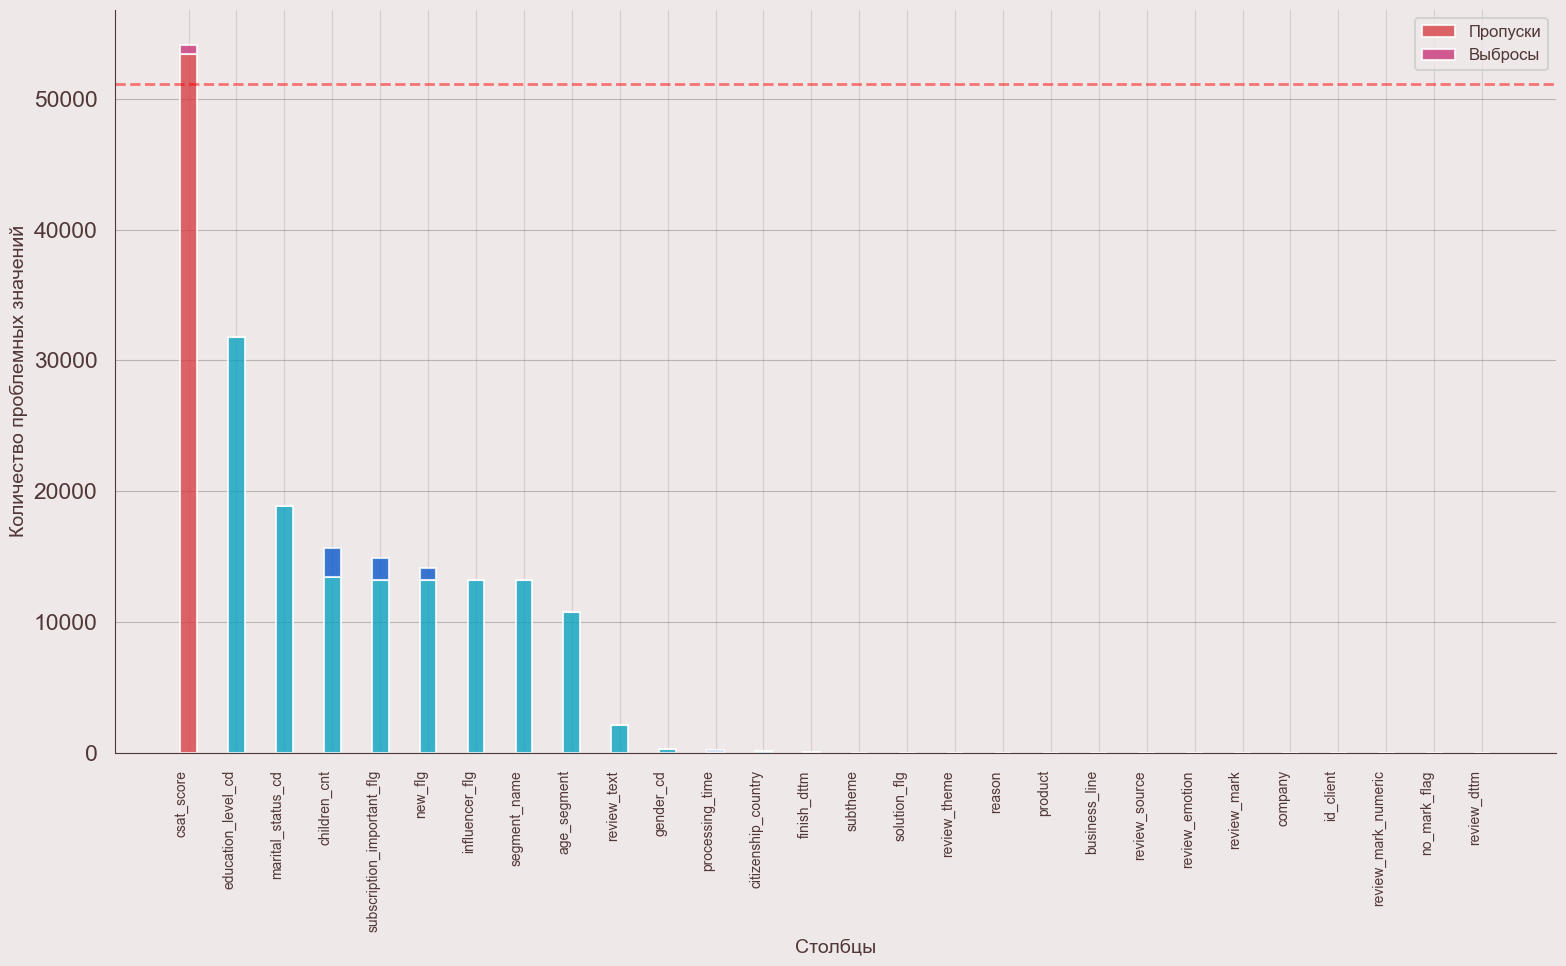


⚠️ КРАСНЫМ выделены столбцы с критическими пропусками (>90%), которые непригодны для анализа


In [153]:
# Гистограмма: Пропуски и выбросы с выделением удаленных столбцов
plt.figure(figsize=(16, 10))

# Берем топ-30 столбцов по количеству проблем
top_columns = columns_df.head(30).copy()

# Позиции для графика
x = np.arange(len(top_columns))
width = 0.35

# Создаем массивы для графика
missing = top_columns['missing_count'].values
outliers = top_columns['outliers_count'].values
is_deleted = top_columns['is_deleted'].values

# Цвета: красный для удаленных, голубой для остальных
colors_missing = ['#D64045' if deleted else colors_dict['cyan'] for deleted in is_deleted]
colors_outliers = ['#C93679' if deleted else colors_dict['blue'] for deleted in is_deleted]

# Создаем stacked bar chart
bars1 = plt.bar(x, missing, width, label='Пропуски', color=colors_missing, alpha=0.8)
bars2 = plt.bar(x, outliers, width, bottom=missing, label='Выбросы', color=colors_outliers, alpha=0.8)

# Настройки графика
plt.ylabel('Количество проблемных значений', fontsize=14)
plt.xlabel('Столбцы', fontsize=14)
plt.xticks(x, top_columns['column'], rotation=90, ha='right', fontsize=10)
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Добавляем линию для 90% от общего количества строк (критический уровень)
critical_line = len(df) * 0.9
plt.axhline(y=critical_line, color='red', linestyle='--', linewidth=2, alpha=0.5, 
           label=f'Критический уровень (90% от {len(df)} строк)')

plt.tight_layout()
plt.show()

print(f"\n⚠️ КРАСНЫМ выделены столбцы с критическими пропусками (>90%), которые непригодны для анализа")

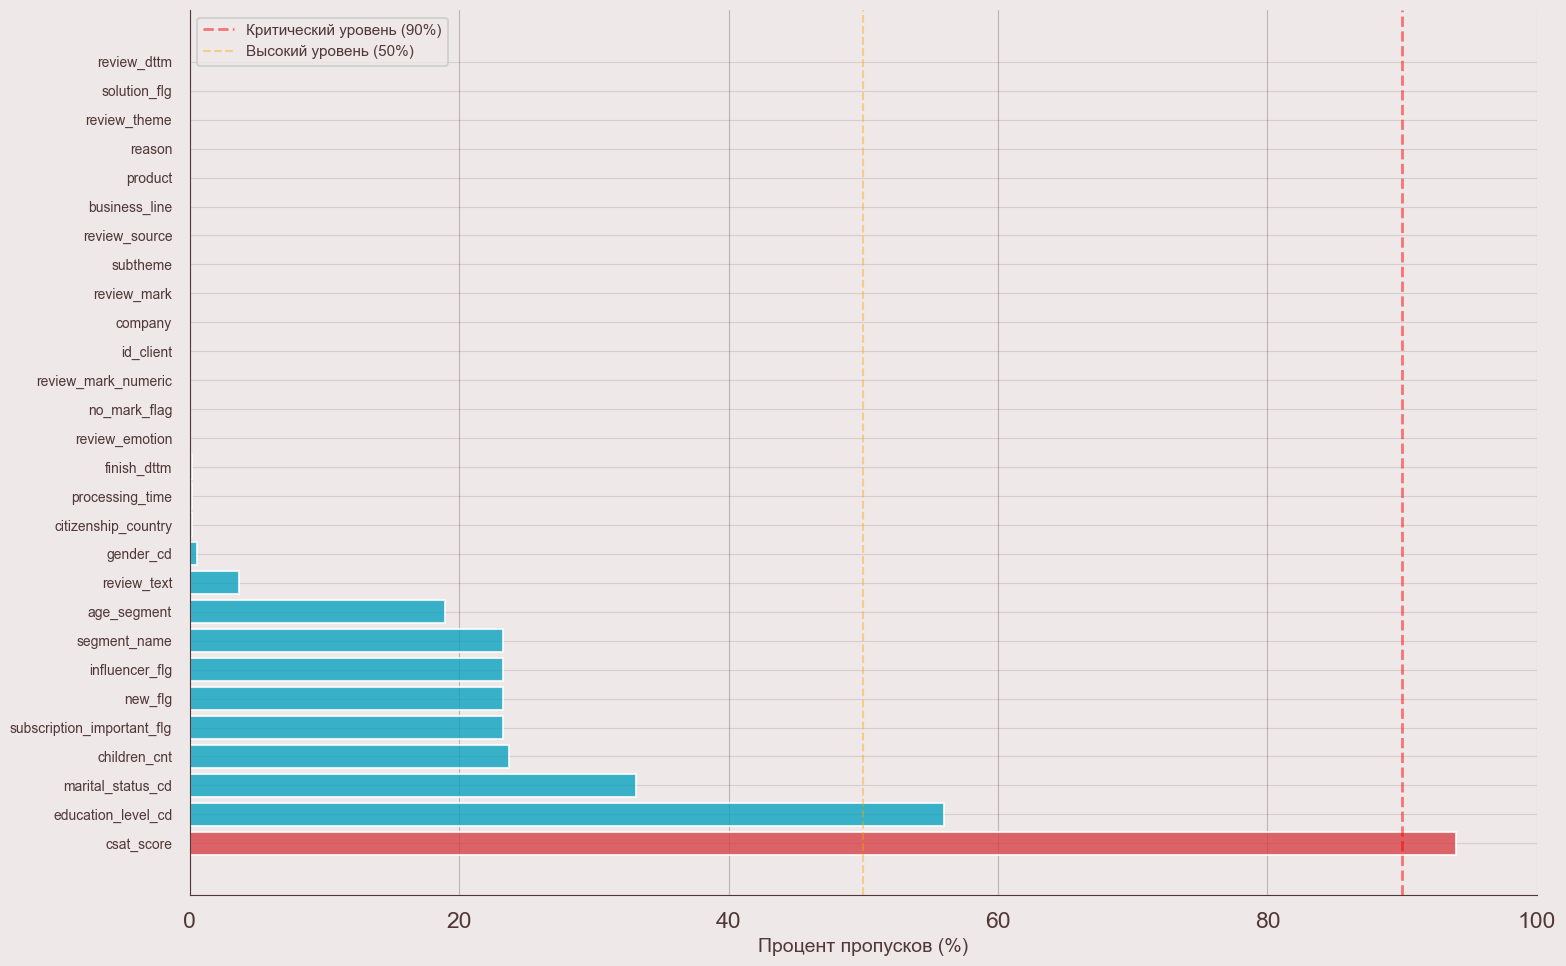


📊 Столбцы отсортированы по проценту пропусков
🔴 КРАСНЫМ - столбцы с критическими пропусками (>90%)
🔵 ГОЛУБЫМ - все остальные столбцы


In [154]:
# Дополнительный график: Процентное соотношение пропусков по всем столбцам
plt.figure(figsize=(16, 10))

# Сортируем по проценту пропусков
columns_sorted = columns_df.sort_values('missing_pct', ascending=False).head(30)

# Создаем цвета в зависимости от того, был ли столбец "удален"
bar_colors = ['#D64045' if deleted else colors_dict['cyan'] 
              for deleted in columns_sorted['is_deleted']]

# Создаем горизонтальный bar chart
plt.barh(range(len(columns_sorted)), columns_sorted['missing_pct'], color=bar_colors, alpha=0.8)

# Настройки
plt.yticks(range(len(columns_sorted)), columns_sorted['column'], fontsize=10)
plt.xlabel('Процент пропусков (%)', fontsize=14)
plt.axvline(x=90, color='red', linestyle='--', linewidth=2, alpha=0.5, 
           label='Критический уровень (90%)')
plt.axvline(x=50, color='orange', linestyle='--', linewidth=1.5, alpha=0.4, 
           label='Высокий уровень (50%)')
plt.legend(fontsize=11)
plt.grid(axis='x', alpha=0.3)
plt.xlim(0, 100)

plt.tight_layout()
plt.show()

print("\n📊 Столбцы отсортированы по проценту пропусков")
print("🔴 КРАСНЫМ - столбцы с критическими пропусками (>90%)")
print("🔵 ГОЛУБЫМ - все остальные столбцы")

СТАТИСТИКА ПО ВЫБРОСАМ

Столбцов с выбросами: 5

Топ-10 столбцов по количеству выбросов:

  children_cnt                  :   2172 выбросов ( 3.82%)
  subscription_important_flg    :   1684 выбросов ( 2.96%)
  new_flg                       :    942 выбросов ( 1.66%)
  csat_score                    :    673 выбросов ( 1.18%)
  processing_time               :    151 выбросов ( 0.27%)


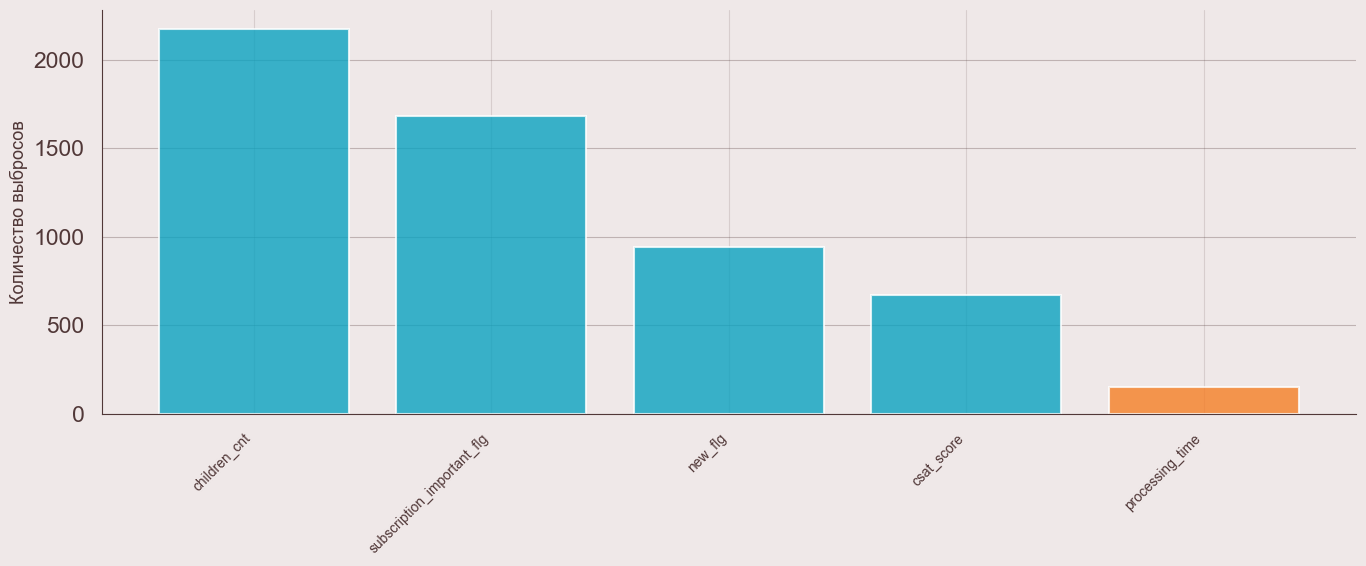


🟠 ОРАНЖЕВЫМ выделен processing_time (выбросы обрабатывались отдельно)


In [157]:
# Дополнительная статистика по выбросам
outliers_df = columns_df[columns_df['outliers_count'] > 0].sort_values('outliers_count', ascending=False)

print("="*80)
print("СТАТИСТИКА ПО ВЫБРОСАМ")
print("="*80)

if len(outliers_df) > 0:
    print(f"\nСтолбцов с выбросами: {len(outliers_df)}")
    print(f"\nТоп-10 столбцов по количеству выбросов:\n")
    for idx, row in outliers_df.head(10).iterrows():
        outlier_pct = (row['outliers_count'] / len(df)) * 100
        print(f"  {row['column']:30s}: {row['outliers_count']:6d} выбросов ({outlier_pct:5.2f}%)")
    
    # График распределения выбросов
    if len(outliers_df) >= 3:
        plt.figure(figsize=(14, 6))
        top_outliers = outliers_df.head(15)
        
        # Используем цвета из палитры
        color_cyan = '#0AA2C0'
        color_orange = '#F57F25'
        colors_bars = [color_cyan if col != 'processing_time' else color_orange 
                      for col in top_outliers['column']]
        
        plt.bar(range(len(top_outliers)), top_outliers['outliers_count'], color=colors_bars, alpha=0.8)
        plt.xticks(range(len(top_outliers)), top_outliers['column'], rotation=45, ha='right', fontsize=10)
        plt.ylabel('Количество выбросов', fontsize=13)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print("\n🟠 ОРАНЖЕВЫМ выделен processing_time (выбросы обрабатывались отдельно)")
else:
    print("\nВыбросов не обнаружено")